# Transport Mode Choice Analysis with Tree-Based Ensemble Methods

This notebook builds and compares multiple tree-based machine learning models for predicting transport mode choices (PT, Drive, Cycle, Walk), including:
- Decision Tree
- Random Forest
- LightGBM
- XGBoost

The analysis includes hyperparameter tuning, model evaluation, SHAP interpretability, and comparative performance analysis.

In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Bayesian optimization for hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

## 1. Import Libraries

Import all required Python libraries for data processing, tree-based models, visualization, and interpretability analysis.

## 2. Data Loading and Exploration

Load the transport dataset containing trip records with mode choices and attributes.

In [2]:
df = pd.read_csv(r"C:\Users\crist\Documents\Cristian\Advanced Data Analysis Code\Data\dataset.csv")

## 3. Feature Engineering

Create new features to capture important relationships and patterns in the data:
- **PT modal shares**: Proportion of bus vs rail in public transport
- **PT penalty index**: Composite measure of PT friction (walking, waiting, interchanges)
- **Friction variables**: Binary indicators for interchange patterns and PT mode combinations
- **Household size**: Number of people in the household
- **PT in-vehicle time**: Total time spent on buses and trains

In [3]:
# Calculate PT modal shares (to avoid division by zero, add small epsilon)
df['pt_share_bus'] = df['dur_pt_bus'] / (df['dur_pt_bus'] + df['dur_pt_rail'] + 1e-6)
df['pt_share_rail'] = 1 - df['pt_share_bus']
# Create the PT penalty index
df['pt_penalty_index'] = (df['dur_pt_access'] + df['dur_pt_int_walking'] +  # total walking time
                         df['dur_pt_int_waiting'] +  # total waiting time
                         df['pt_n_interchanges'] * 0.1)  # interchange penalty

In [4]:
# Creating Friction variables
df['has_interchange'] = (df['pt_n_interchanges'] > 0).astype(int)
df['multi_interchange'] = (df['pt_n_interchanges'] >= 2).astype(int)
df['is_bus_only'] = ((df['dur_pt_rail'] == 0) & (df['dur_pt_bus'] > 0)).astype(int)
df['is_rail_only'] = ((df['dur_pt_bus'] == 0) & (df['dur_pt_rail'] > 0)).astype(int)
df['is_mixed_pt'] = ((df['dur_pt_bus'] > 0) & (df['dur_pt_rail'] > 0)).astype(int)

In [5]:
# Create a new variable for total in-vehicle public transport time
df['pt_in_vehicle'] = df['dur_pt_bus'] + df['dur_pt_rail']

In [6]:
# Calculate max person_n for each household_id and add as n_household column
household_max = df.groupby('household_id')['person_n'].max().reset_index()
household_max.columns = ['household_id', 'n_household']

# Merge back to the main dataset
df = df.merge(household_max, on='household_id', how='left')

## 4. Data Preparation and Encoding

Prepare the data for modeling:
- Select relevant features
- Encode the target variable (travel_mode)
- One-hot encode categorical variables (purpose)
- Create feature matrix X and target vector y

In [7]:
# Select specific columns from the data
# selected_data = df[['travel_mode', 'purpose', 'travel_month', 'travel_date', 'day_of_week', 'start_time_linear', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total', 'driving_traffic_percent', 'pt_n_interchanges', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting', 'car_ownership', 'female', 'driving_license', 'age', n_household']]
selected_data = df[['travel_mode', 'purpose', 'travel_month', 'travel_date', 'day_of_week', 'start_time_linear', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total', 'driving_traffic_percent', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting', 'car_ownership', 'female', 'driving_license', 'age', 'pt_share_bus', 'pt_share_rail', 'pt_penalty_index', 'has_interchange', 'multi_interchange', 'is_bus_only', 'is_rail_only', 'is_mixed_pt', 'pt_in_vehicle', 'n_household']]


In [8]:
# Check actual values first:
print(selected_data['travel_mode'].unique())
# Clean whitespace before mapping:
selected_data['travel_mode'] = selected_data['travel_mode'].str.strip().str.lower()

['drive' 'pt' 'walk' 'cycle']


In [9]:
# Create mapping dictionary for travel modes
mode_mapping = {'pt': 0, 'drive': 1, 'cycle': 2, 'walk': 3}

# Convert travel_mode to integers using the mapping
selected_data['travel_mode'] = selected_data['travel_mode'].map(mode_mapping)

In [10]:
# One-hot encode the 'purpose' column
purpose_dummies = pd.get_dummies(selected_data['purpose'], prefix='purpose')

# Convert boolean to integer (0/1)
purpose_dummies = purpose_dummies.astype(int)

# Concatenate the dummy variables with the original dataframe
selected_data = pd.concat([selected_data, purpose_dummies], axis=1)

# Drop the original 'purpose' column
selected_data = selected_data.drop('purpose', axis=1)

In [11]:
# extract power and weight as data matrix X
X = selected_data.drop(['travel_mode'], axis=1).values
# extract origin as target vector y
y = selected_data['travel_mode'].values

In [12]:
# Calculate the size of matrix X
print(f"Shape of X: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Total size (elements): {X.size}")


Shape of X: (81086, 36)
Number of samples: 81086
Number of features: 36
Total size (elements): 2919096


In [13]:
# Check the shape and contents of y
print(f"Shape of y: {y.shape}")
print(f"Value counts in y:")
unique, counts = pd.Series(y).value_counts().sort_index().index, pd.Series(y).value_counts().sort_index().values
for val, count in zip(unique, counts):
    print(f"  {val}: {count}")

Shape of y: (81086,)
Value counts in y:
  0: 28605
  1: 35808
  2: 2405
  3: 14268


## 5. Model Training and Evaluation

Train and evaluate multiple tree-based ensemble models with hyperparameter tuning.

### 5.1 Decision Tree (Baseline)

In [22]:
# split into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# learn decision tree
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,y_train)
y_predicted = tree.predict(X_test)

# compute confusion matrix
print(confusion_matrix(y_true=y_test, y_pred=y_predicted))

# compute accuracy
print(accuracy_score(y_true=y_test, y_pred=y_predicted)) # 0.620253164556962

[[4094 1104  176  371]
 [1027 5446  145  521]
 [ 154  137  111   76]
 [ 424  495   80 1857]]
0.7095819459859416


### 5.2 Random Forest with Hyperparameter Tuning

In [20]:
# split into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# learn decision tree
tree = RandomForestClassifier(criterion='entropy')
tree.fit(X_train,y_train)
y_predicted = tree.predict(X_test)

# compute confusion matrix
print(confusion_matrix(y_true=y_test, y_pred=y_predicted))

# compute accuracy
print(accuracy_score(y_true=y_test, y_pred=y_predicted))

[[4687  838    1  219]
 [ 590 6286    0  263]
 [ 220  147   28   83]
 [ 308  465    2 2081]]
0.8066346035269454


In [103]:
# Hyperparameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Define a smaller parameter grid for demonstration
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
rf_grid = RandomForestClassifier(criterion='entropy', random_state=0)
grid_search = GridSearchCV(
    rf_grid, param_grid, 
    cv=3,  # 3-fold cross-validation for speed
    scoring='neg_log_loss', 
    n_jobs=-1,  # Use all available processors
    verbose=1  # Show progress
)

print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation NLL: {-grid_search.best_score_:.4f}")

# Use the best model for predictions
best_rf = grid_search.best_estimator_
y_predicted_tuned = best_rf.predict(X_test)

print("\nTuned Random Forest Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_true=y_test, y_pred=y_predicted_tuned))
from sklearn.metrics import log_loss
test_nll = log_loss(y_test, best_rf.predict_proba(X_test))
print(f"Test NLL: {test_nll:.4f}")

Starting hyperparameter tuning...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation NLL: 0.5903

Tuned Random Forest Results:
Confusion Matrix:
[[4651  859    1  234]
 [ 578 6301    0  260]
 [ 224  152   23   79]
 [ 300  494    2 2060]]
Test NLL: 0.5505


In [23]:
# Build Random Forest with best parameters from grid search
best_params_rf = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'n_estimators': 150
}

print(f"{'='*60}")
print("RANDOM FOREST - BEST MODEL")
print(f"{'='*60}")
print("\nBest Random Forest parameters:")
for param, value in best_params_rf.items():
    print(f"  {param}: {value}")

# Create Random Forest model with best parameters
best_rf = RandomForestClassifier(
    criterion='entropy',
    random_state=0,
    **best_params_rf
)

print("\nTraining Random Forest with best parameters...")
best_rf.fit(X_train, y_train)

# Make predictions
y_predicted_tuned = best_rf.predict(X_test)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_predicted_tuned):.4f}")

print("\nRandom Forest Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_predicted_tuned))

# Calculate test set NLL
from sklearn.metrics import log_loss
test_nll = log_loss(y_test, best_rf.predict_proba(X_test))
print(f"Test NLL: {test_nll:.4f}")

RANDOM FOREST - BEST MODEL

Best Random Forest parameters:
  max_depth: 20
  max_features: sqrt
  min_samples_split: 2
  n_estimators: 150

Training Random Forest with best parameters...

EVALUATION METRICS

Test Accuracy: 0.8037

Random Forest Results:
Confusion Matrix:
[[4651  859    1  234]
 [ 578 6301    0  260]
 [ 224  152   23   79]
 [ 300  494    2 2060]]
Test NLL: 0.5505


In [24]:
# Get feature importance from the Random Forest model
feature_importance = tree.feature_importances_

# Get feature names (excluding 'travel_mode' which is the target)
feature_names = selected_data.drop(['travel_mode'], axis=1).columns

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(importance_df.to_string(index=False))

Feature Importance (Random Forest):
                feature  importance
               distance    0.188880
          car_ownership    0.122704
driving_traffic_percent    0.084410
            dur_walking    0.058256
                    age    0.054257
            dur_driving    0.042282
      start_time_linear    0.040549
            travel_date    0.036621
     cost_driving_total    0.034626
       pt_penalty_index    0.034316
            dur_cycling    0.031432
           dur_pt_total    0.030500
          dur_pt_access    0.029257
           travel_month    0.028199
            day_of_week    0.024670
        driving_license    0.017931
            n_household    0.016627
          pt_in_vehicle    0.016099
           cost_transit    0.015135
            dur_pt_rail    0.013744
          pt_share_rail    0.012311
             dur_pt_bus    0.011880
           pt_share_bus    0.009718
                 female    0.008070
            purpose_HBO    0.007224
            purpose_HBW    0


RF MODEL EVALUATION

Prediction accuracy (weighted if applicable): 0.804


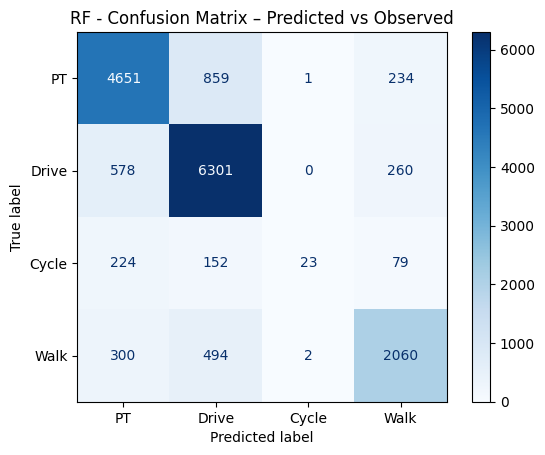


Per-class Accuracy (Recall):
PT: 0.8096 (4651.0/5745.0)
Drive: 0.8826 (6301.0/7139.0)
Cycle: 0.0481 (23.0/478.0)
Walk: 0.7213 (2060.0/2856.0)

F1 SCORES

Per-class F1 Scores:
  PT      : 0.8090
  Drive   : 0.8432
  Cycle   : 0.0913
  Walk    : 0.7506

Macro Average F1 Score: 0.6235

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          PT       0.81      0.81      0.81      5745
       Drive       0.81      0.88      0.84      7139
       Cycle       0.88      0.05      0.09       478
        Walk       0.78      0.72      0.75      2856

    accuracy                           0.80     16218
   macro avg       0.82      0.62      0.62     16218
weighted avg       0.81      0.80      0.79     16218



In [25]:
# ---------------------------------------------------------------
# RF - Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
# Get predicted classes for RF
y_pred_rf_idx = y_predicted_tuned

# Use same weights as other models
w = np.ones(len(y_test))
w_sum = w.sum()

acc_weighted_xgb = (w * (y_pred_rf_idx == y_test)).sum() / w_sum
print(f"\n{'='*60}")
print("RF MODEL EVALUATION")
print(f"{'='*60}")
print(f"\nPrediction accuracy (weighted if applicable): {acc_weighted_xgb:.3f}")

cm_xgb = confusion_matrix(y_test, y_pred_rf_idx, labels=[0, 1, 2, 3], sample_weight=w)
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=['PT', 'Drive', 'Cycle', 'Walk'])
disp_xgb.plot(cmap='Blues', values_format='.0f')
plt.title("RF - Confusion Matrix – Predicted vs Observed")
plt.show()

# Calculate per-class accuracy (recall)
print("\nPer-class Accuracy (Recall):")
for i, mode in enumerate(['PT', 'Drive', 'Cycle', 'Walk']):
    class_accuracy = cm_xgb[i, i] / cm_xgb[i, :].sum()
    print(f"{mode}: {class_accuracy:.4f} ({cm_xgb[i, i]}/{cm_xgb[i, :].sum()})")

# ---------------------------------------------------------------
# F1 Scores (Per-class and Macro Average)
# ---------------------------------------------------------------
from sklearn.metrics import f1_score, classification_report

target_names = ['PT', 'Drive', 'Cycle', 'Walk']

# Calculate per-class F1 scores
f1_per_class = f1_score(y_test, y_pred_rf_idx, average=None, labels=[0, 1, 2, 3])

# Calculate macro average F1 score
macro_f1 = f1_score(y_test, y_pred_rf_idx, average='macro')

print("\n" + "="*60)
print("F1 SCORES")
print("="*60)
print("\nPer-class F1 Scores:")
for i, (mode, f1) in enumerate(zip(target_names, f1_per_class)):
    print(f"  {mode:8s}: {f1:.4f}")

print(f"\nMacro Average F1 Score: {macro_f1:.4f}")

# Full classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_rf_idx, target_names=target_names))

True shares:
 0    0.354236
1    0.440190
2    0.029473
3    0.176101
Name: proportion, dtype: float64

Predicted shares (probability mean):
 0    0.352235
1    0.441593
2    0.031010
3    0.175162
dtype: float64


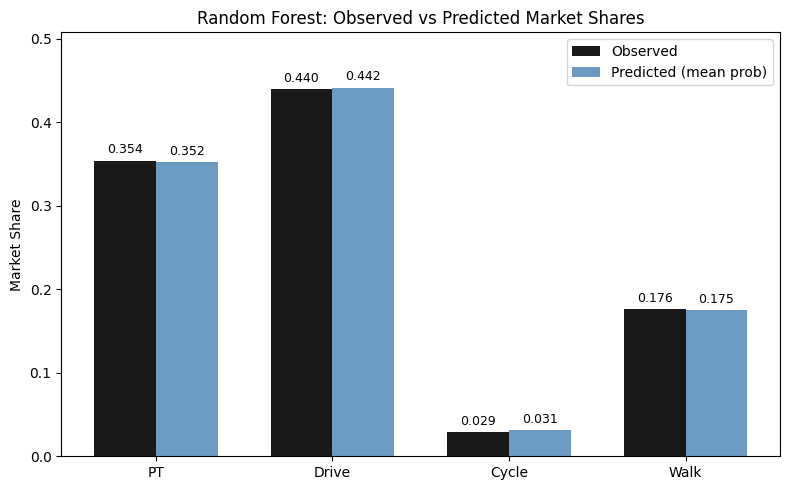

In [26]:
# Compare Random Forest predicted market shares with observed market shares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get predictions from the RF model
proba = best_rf.predict_proba(X_test)
pred_shares = pd.Series(proba.mean(axis=0), index=best_rf.classes_)
true_shares = pd.Series(y_test).value_counts(normalize=True).reindex(best_rf.classes_)

print("True shares:\n", true_shares)
print("\nPredicted shares (probability mean):\n", pred_shares)

# Bar plot: observed vs predicted (mean probability) market shares
class_labels = [target_names[int(c)] for c in best_rf.classes_]
observed = true_shares.reindex(best_rf.classes_).fillna(0).values
predicted = pred_shares.reindex(best_rf.classes_).fillna(0).values

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_obs = ax.bar(x - width/2, observed, width, label='Observed', color='black', alpha=0.9)
bars_pred = ax.bar(x + width/2, predicted, width, label='Predicted (mean prob)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylabel('Market Share')
ax.set_title('Random Forest: Observed vs Predicted Market Shares')
ax.legend()
ax.set_ylim(0, max(observed.max(), predicted.max()) * 1.15)

for bars in (bars_obs, bars_pred):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [142]:
# ==============================================================================
# SCENARIO ANALYSIS: DRIVING COST & TIME (COUNTERFACTUAL) - Random Forest
# ==============================================================================
# Effect 1: Increase driving cost (cost_driving_total) by +10%, +20%, +30%
# Effect 2: Increase driving time (dur_driving) by +2%, +5%, +8% (scaled 1:5 with cost)
# ==============================================================================

# Get feature indices
feature_names_list = selected_data.drop(['travel_mode'], axis=1).columns.tolist()
cost_idx = feature_names_list.index('cost_driving_total')
time_idx = feature_names_list.index('dur_driving')

# Define scenarios
cost_increases = [0.10, 0.20, 0.30]
time_increases = [0.02, 0.05, 0.08]

# Get baseline predictions using Random Forest
probs_baseline_rf = best_rf.predict_proba(X_test)
baseline_market_share_rf = probs_baseline_rf.mean(axis=0)

# Create summary table data
summary_data_rf = []
baseline_row_rf = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share_rf[0]:.4f}",
    'Drive': f"{baseline_market_share_rf[1]:.4f}",
    'Cycle': f"{baseline_market_share_rf[2]:.4f}",
    'Walk': f"{baseline_market_share_rf[3]:.4f}"
}
summary_data_rf.append(baseline_row_rf)

# Run scenarios
scenario_names_rf = [
    'Cost +10%, Time +2%',
    'Cost +20%, Time +5%',
    'Cost +30%, Time +8%'
]

for cost_increase, time_increase, scenario_name in zip(cost_increases, time_increases, scenario_names_rf):
    # Create counterfactual data
    X_scenario_rf = X_test.copy().astype(float)
    X_scenario_rf[:, cost_idx] = X_scenario_rf[:, cost_idx] * (1 + cost_increase)
    X_scenario_rf[:, time_idx] = X_scenario_rf[:, time_idx] * (1 + time_increase)
    
    # Get predictions
    probs_scenario_rf = best_rf.predict_proba(X_scenario_rf)
    market_share_scenario_rf = probs_scenario_rf.mean(axis=0)
    
    # Add to summary
    summary_data_rf.append({
        'Scenario': scenario_name,
        'PT': f"{market_share_scenario_rf[0]:.4f}",
        'Drive': f"{market_share_scenario_rf[1]:.4f}",
        'Cycle': f"{market_share_scenario_rf[2]:.4f}",
        'Walk': f"{market_share_scenario_rf[3]:.4f}"
    })

# Display summary table
print("\n" + "="*80)
print("DRIVING COST & TIME SCENARIO ANALYSIS - Random Forest (Counterfactual)")
print("="*80)
summary_df_rf = pd.DataFrame(summary_data_rf)
print(summary_df_rf.to_string(index=False))

# Save the scenario summary table to Excel
summary_df_rf.to_excel("rf_scenario_analysis.xlsx", index=False)



DRIVING COST & TIME SCENARIO ANALYSIS - Random Forest (Counterfactual)
           Scenario     PT  Drive  Cycle   Walk
           Baseline 0.3522 0.4416 0.0310 0.1752
Cost +10%, Time +2% 0.3552 0.4396 0.0311 0.1741
Cost +20%, Time +5% 0.3582 0.4364 0.0316 0.1738
Cost +30%, Time +8% 0.3610 0.4330 0.0321 0.1740


In [143]:
# ==============================================================================
# SCENARIO ANALYSIS: PT SERVICE IMPROVEMENT (COUNTERFACTUAL) - Random Forest
# ==============================================================================
# Effect 1: Reduce PT access and waiting times by −10%, −20%, −30%
# Effect 2: Reduce transfer penalty index by −10%, −20%, −30%
# ==============================================================================

# Get feature indices for PT features
feature_names_list = selected_data.drop(['travel_mode'], axis=1).columns.tolist()
pt_access_idx = feature_names_list.index('dur_pt_access')
pt_wait_idx = feature_names_list.index('dur_pt_int_waiting')
pt_penalty_idx = feature_names_list.index('pt_penalty_index')

# Define PT scenarios
pt_scenarios_rf = [
    ('PT Access/Wait -10% / Penalty -10%', -0.10, -0.10),
    ('PT Access/Wait -20% / Penalty -20%', -0.20, -0.20),
    ('PT Access/Wait -30% / Penalty -30%', -0.30, -0.30),
]

# Get baseline predictions using Random Forest
probs_baseline_pt_rf = best_rf.predict_proba(X_test)
baseline_market_share_pt_rf = probs_baseline_pt_rf.mean(axis=0)

# Create summary table data
summary_data_pt_rf = []
baseline_row_pt_rf = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share_pt_rf[0]:.4f}",
    'Drive': f"{baseline_market_share_pt_rf[1]:.4f}",
    'Cycle': f"{baseline_market_share_pt_rf[2]:.4f}",
    'Walk': f"{baseline_market_share_pt_rf[3]:.4f}"
}
summary_data_pt_rf.append(baseline_row_pt_rf)

# Run PT scenarios
for scenario_name, time_reduction, transfer_reduction in pt_scenarios_rf:
    # Create counterfactual data
    X_scenario_pt_rf = X_test.copy().astype(float)
    X_scenario_pt_rf[:, pt_access_idx] = X_scenario_pt_rf[:, pt_access_idx] * (1 + time_reduction)
    X_scenario_pt_rf[:, pt_wait_idx] = X_scenario_pt_rf[:, pt_wait_idx] * (1 + time_reduction)
    X_scenario_pt_rf[:, pt_penalty_idx] = X_scenario_pt_rf[:, pt_penalty_idx] * (1 + transfer_reduction)
    
    # Get predictions
    probs_scenario_pt_rf = best_rf.predict_proba(X_scenario_pt_rf)
    market_share_scenario_pt_rf = probs_scenario_pt_rf.mean(axis=0)
    
    # Add to summary
    summary_data_pt_rf.append({
        'Scenario': scenario_name,
        'PT': f"{market_share_scenario_pt_rf[0]:.4f}",
        'Drive': f"{market_share_scenario_pt_rf[1]:.4f}",
        'Cycle': f"{market_share_scenario_pt_rf[2]:.4f}",
        'Walk': f"{market_share_scenario_pt_rf[3]:.4f}"
    })

# Display summary table
print("\n" + "="*80)
print("PT SERVICE IMPROVEMENT SCENARIO ANALYSIS - Random Forest (Counterfactual)")
print("="*80)
summary_df_pt_rf = pd.DataFrame(summary_data_pt_rf)
print(summary_df_pt_rf.to_string(index=False))
# Save the PT scenario summary table to Excel
summary_df_pt_rf.to_excel("rf_pt_scenario_analysis.xlsx", index=False)



PT SERVICE IMPROVEMENT SCENARIO ANALYSIS - Random Forest (Counterfactual)
                          Scenario     PT  Drive  Cycle   Walk
                          Baseline 0.3522 0.4416 0.0310 0.1752
PT Access/Wait -10% / Penalty -10% 0.3616 0.4333 0.0307 0.1744
PT Access/Wait -20% / Penalty -20% 0.3705 0.4254 0.0307 0.1734
PT Access/Wait -30% / Penalty -30% 0.3792 0.4174 0.0310 0.1724


#### 5.2.1 Random Forest: Feature Importance Analysis

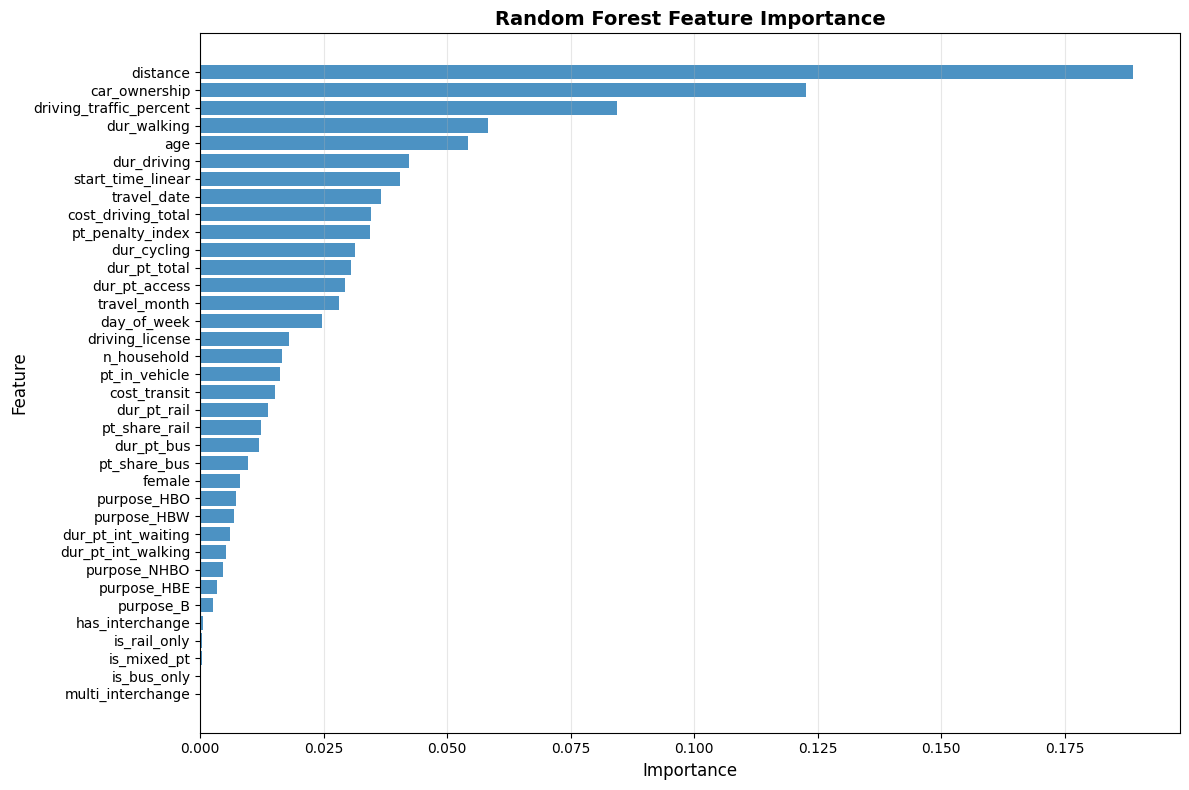

In [28]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['importance'], alpha=0.8)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

### 5.3 LightGBM with Bayesian Hyperparameter Optimization

In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from skopt import BayesSearchCV
from skopt.space import Integer, Real

from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

# LightGBM Bayesian Optimization with Negative Log-Likelihood (NLL)
print(f"\n{'='*60}")
print("LIGHTGBM - BAYESIAN OPTIMIZATION (NLL)")
print(f"{'='*60}")

# Determine number of classes
n_classes = len(np.unique(y_train))

lgb_model = lgb.LGBMClassifier(
    random_state=0,
    verbose=-1,
    n_jobs=-1,
    objective="multiclass" if n_classes > 2 else "binary",
    num_class=n_classes if n_classes > 2 else None,
)

lgb_search_spaces = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 150),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_samples': Integer(5, 50),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0)
}

# Use sklearn's built-in 'neg_log_loss' scorer
lgb_bayes_search = BayesSearchCV(
    lgb_model,
    lgb_search_spaces,
    n_iter=50,
    cv=3,
    scoring='neg_log_loss',  # Built-in scorer
    n_jobs=-1,
    verbose=1,
    random_state=0
)

print("\nStarting LightGBM Bayesian optimization...")
print(f"Search space: {lgb_search_spaces}")
print("Optimization metric: Negative Log-Likelihood (NLL)")
lgb_bayes_search.fit(X_train, y_train)

print("\n" + "="*60)
print("Best LightGBM parameters:")
for param, value in lgb_bayes_search.best_params_.items():
    print(f"  {param}: {value}")

# BayesSearchCV stores NEGATIVE log loss, so flip sign to get actual NLL
best_cv_nll = -lgb_bayes_search.best_score_
print(f"\nBest LightGBM CV NLL: {best_cv_nll:.4f}")

# Make predictions with best LightGBM model
best_lgb = lgb_bayes_search.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)

print("\nLightGBM Test Set Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")

# Calculate test set NLL
test_nll = log_loss(y_test, best_lgb.predict_proba(X_test))
print(f"Test NLL: {test_nll:.4f}")

# Display optimization history
print("\n" + "="*60)
print("BAYESIAN OPTIMIZATION HISTORY")
print("="*60)
print("\nTop 5 parameter combinations:")
results_df_lgb = pd.DataFrame(lgb_bayes_search.cv_results_)
top_5_lgb = results_df_lgb.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
for idx, row in top_5_lgb.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    # Convert negative log loss back to positive NLL for display
    nll_value = -row['mean_test_score']
    nll_std = row['std_test_score']
    print(f"  NLL: {nll_value:.4f} (+/- {nll_std:.4f})")
    print(f"  Params: {row['params']}")


LIGHTGBM - BAYESIAN OPTIMIZATION (NLL)

Starting LightGBM Bayesian optimization...
Search space: {'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=3, high=15, prior='uniform', transform='identity'), 'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='identity'), 'num_leaves': Integer(low=20, high=150, prior='uniform', transform='identity'), 'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='identity'), 'colsample_bytree': Real(low=0.6, high=1.0, prior='uniform', transform='identity'), 'min_child_samples': Integer(low=5, high=50, prior='uniform', transform='identity'), 'reg_alpha': Real(low=0, high=1.0, prior='uniform', transform='identity'), 'reg_lambda': Real(low=0, high=1.0, prior='uniform', transform='identity')}
Optimization metric: Negative Log-Likelihood (NLL)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3

c:\Users\crist\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Test Set Results:
Confusion Matrix:
[[4640  854    6  245]
 [ 609 6258    4  268]
 [ 216  147   34   81]
 [ 363  445    3 2045]]
Test Accuracy: 0.8002


c:\Users\crist\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test NLL: 0.5184

BAYESIAN OPTIMIZATION HISTORY

Top 5 parameter combinations:

Rank 1:
  NLL: 0.5485 (+/- 0.0013)
  Params: OrderedDict({'colsample_bytree': 0.7736836091369248, 'learning_rate': 0.0816208678935021, 'max_depth': 15, 'min_child_samples': 5, 'n_estimators': 199, 'num_leaves': 150, 'reg_alpha': 0.8334658135091371, 'reg_lambda': 1.0, 'subsample': 0.7928839507660707})

Rank 2:
  NLL: 0.5490 (+/- 0.0027)
  Params: OrderedDict({'colsample_bytree': 0.6, 'learning_rate': 0.059245050266140895, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 311, 'num_leaves': 150, 'reg_alpha': 0.01745435778776672, 'reg_lambda': 1.0, 'subsample': 1.0})

Rank 3:
  NLL: 0.5514 (+/- 0.0015)
  Params: OrderedDict({'colsample_bytree': 0.6875576256978616, 'learning_rate': 0.09715351659850759, 'max_depth': 14, 'min_child_samples': 5, 'n_estimators': 196, 'num_leaves': 150, 'reg_alpha': 0.8833198519532401, 'reg_lambda': 0.0, 'subsample': 0.6})

Rank 4:
  NLL: 0.5524 (+/- 0.0012)
  Params: Ordered

In [29]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

# LightGBM model with best parameters
print(f"\n{'='*60}")
print("LIGHTGBM - BEST MODEL")
print(f"{'='*60}")

# Best parameters from tuning
best_lgb_params = {
    'colsample_bytree': 0.8,
    'gamma': 0.3,
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 30,
    'n_estimators': 1400,
    'subsample': 0.8,
}

print("\nBest LightGBM parameters:")
for param, value in best_lgb_params.items():
    print(f"  {param}: {value}")

# Determine number of classes
n_classes = len(np.unique(y_train))

# Create LightGBM model with best parameters
lgb_model = lgb.LGBMClassifier(
    random_state=0,
    verbose=-1,
    n_jobs=-1,
    **best_lgb_params
)

print("\nTraining LightGBM with best parameters...")
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)

# Calculate metrics
test_accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
test_nll_lgb = log_loss(y_test, y_pred_proba_lgb)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"\nTest Accuracy: {test_accuracy_lgb:.4f}")
print(f"Test NLL: {test_nll_lgb:.4f}")

print("\nLightGBM Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))

# Store best model
best_lgb = lgb_model



LIGHTGBM - BEST MODEL

Best LightGBM parameters:
  colsample_bytree: 0.8
  gamma: 0.3
  learning_rate: 0.01
  max_depth: 8
  min_child_weight: 30
  n_estimators: 1400
  subsample: 0.8

Training LightGBM with best parameters...

EVALUATION METRICS

Test Accuracy: 0.7660
Test NLL: 0.5972

LightGBM Results:
Confusion Matrix:
[[4461  994    5  285]
 [ 732 6068    0  339]
 [ 219  168    8   83]
 [ 394  576    0 1886]]



LIGHTGBM MODEL EVALUATION

Prediction accuracy (weighted if applicable): 0.766


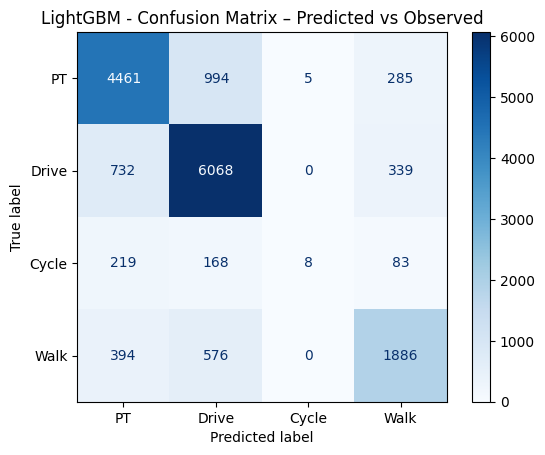


Per-class Accuracy (Recall):
PT: 0.7765 (4461.0/5745.0)
Drive: 0.8500 (6068.0/7139.0)
Cycle: 0.0167 (8.0/478.0)
Walk: 0.6604 (1886.0/2856.0)

Weighted log-likelihood: -9684.757
Average weighted log-likelihood per obs: -0.5972


In [30]:
# ---------------------------------------------------------------
# LightGBM - Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
# Get predicted classes for LightGBM
y_pred_lgb_idx = y_pred_lgb

# Use same weights as other models
w = np.ones(len(y_test))
w_sum = w.sum()

acc_weighted_lgb = (w * (y_pred_lgb_idx == y_test)).sum() / w_sum
print(f"\n{'='*60}")
print("LIGHTGBM MODEL EVALUATION")
print(f"{'='*60}")
print(f"\nPrediction accuracy (weighted if applicable): {acc_weighted_lgb:.3f}")

cm_lgb = confusion_matrix(y_test, y_pred_lgb_idx, labels=[0, 1, 2, 3], sample_weight=w)
disp_lgb = ConfusionMatrixDisplay(cm_lgb, display_labels=['PT', 'Drive', 'Cycle', 'Walk'])
disp_lgb.plot(cmap='Blues', values_format='.0f')
plt.title("LightGBM - Confusion Matrix – Predicted vs Observed")
plt.show()

# Calculate per-class accuracy (recall)
print("\nPer-class Accuracy (Recall):")
for i, mode in enumerate(['PT', 'Drive', 'Cycle', 'Walk']):
    class_accuracy = cm_lgb[i, i] / cm_lgb[i, :].sum()
    print(f"{mode}: {class_accuracy:.4f} ({cm_lgb[i, i]}/{cm_lgb[i, :].sum()})")

# ---------------------------------------------------------------
# Weighted log-likelihood for LightGBM
# ---------------------------------------------------------------
# Get probability for the chosen class for each observation
probs_lgb = best_lgb.predict_proba(X_test)
prob_chosen_lgb = probs_lgb[np.arange(len(y_test)), y_test]
prob_chosen_lgb = np.clip(prob_chosen_lgb, 1e-300, 1)
LL_lgb = np.sum(w * np.log(prob_chosen_lgb))
avg_LL_lgb = LL_lgb / w_sum
print(f"\nWeighted log-likelihood: {LL_lgb:.3f}")
print(f"Average weighted log-likelihood per obs: {avg_LL_lgb:.4f}")

True shares:
 0    0.354236
1    0.440190
2    0.029473
3    0.176101
Name: proportion, dtype: float64
Predicted shares (probability mean):
 0    0.354480
1    0.441945
2    0.029149
3    0.174426
dtype: float64


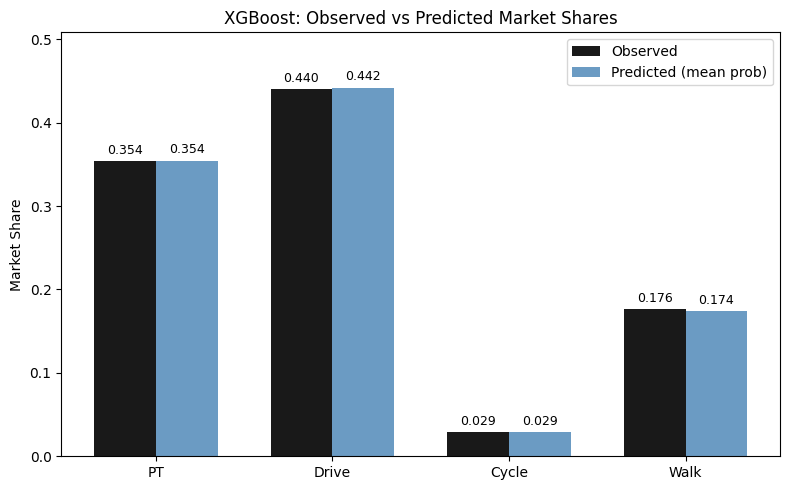

In [31]:
proba = best_lgb.predict_proba(X_test)
pred_shares = pd.Series(proba.mean(axis=0), index=best_lgb.classes_)
true_shares = pd.Series(y_test).value_counts(normalize=True).reindex(best_lgb.classes_)

print("True shares:\n", true_shares)
print("Predicted shares (probability mean):\n", pred_shares)

# Bar plot: observed vs predicted (mean probability) market shares
class_labels = [target_names[int(c)] for c in best_lgb.classes_]
observed = true_shares.reindex(best_lgb.classes_).fillna(0).values
predicted = pred_shares.reindex(best_lgb.classes_).fillna(0).values

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_obs = ax.bar(x - width/2, observed, width, label='Observed', color='black', alpha=0.9)
bars_pred = ax.bar(x + width/2, predicted, width, label='Predicted (mean prob)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylabel('Market Share')
ax.set_title('XGBoost: Observed vs Predicted Market Shares')
ax.legend()
ax.set_ylim(0, max(observed.max(), predicted.max()) * 1.15)

for bars in (bars_obs, bars_pred):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



### 5.4 XGBoost with Bayesian and Grid Search Optimization

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# XGBoost Bayesian Optimization with Negative Log-Likelihood (NLL)
print(f"\n{'='*60}")
print("XGBOOST - BAYESIAN OPTIMIZATION (NLL)")
print(f"{'='*60}")

# Determine number of classes
n_classes = len(np.unique(y_train))

# Fixed learning rate at 0.01
xgb_model = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    learning_rate=0.01,  # Fixed at 0.01
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
)

# Hyperparameter search spaces (including n_estimators)
xgb_search_spaces = {
    'n_estimators': Integer(100, 2000),  # Search for optimal number of trees
    'max_depth': Integer(1, 14),  # Uniform 1:14
    'gamma': Real(0.001, 5.0, prior='log-uniform'),  # Log-uniform 0:5
    'min_child_weight': Real(1.0, 100.0, prior='log-uniform'),  # Log-uniform 1:100
    'subsample': Real(0.5, 1.0, prior='log-uniform'),  # Log-uniform 0.5:1
    'colsample_bytree': Real(0.5, 1.0, prior='log-uniform'),  # Log-uniform 0.5:1
    'colsample_bylevel': Real(0.5, 1.0, prior='log-uniform'),  # Log-uniform 0.5:1
    'reg_alpha': Real(0.001, 1.0, prior='log-uniform'),  # Log-uniform 0:1
    'reg_lambda': Real(1.0, 4.0, prior='log-uniform'),  # Log-uniform 1:4
    'max_delta_step': Real(0.001, 10.0, prior='log-uniform')  # Log-uniform 0:10
}

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Use sklearn's built-in 'neg_log_loss' scorer
xgb_bayes_search = BayesSearchCV(
    xgb_model,
    xgb_search_spaces,
    n_iter=50,
    cv=cv10,
    scoring='neg_log_loss',  # Built-in scorer
    n_jobs=-1,
    verbose=1,
    random_state=0
)

print("\nStarting XGBoost Bayesian optimization...")
print(f"Fixed learning_rate: 0.01")
print(f"Search space: {xgb_search_spaces}")
print("Optimization metric: Negative Log-Likelihood (NLL)")

# Fit with cross-validation (n_estimators will be optimized)
xgb_bayes_search.fit(X_train, y_train)

print("\n" + "="*60)
print("Best XGBoost parameters:")
for param, value in xgb_bayes_search.best_params_.items():
    print(f"  {param}: {value}")

# BayesSearchCV stores NEGATIVE log loss, so flip sign to get actual NLL
best_cv_nll = -xgb_bayes_search.best_score_
print(f"Best XGBoost CV NLL: {best_cv_nll:.4f}")

# Now retrain the best model with early stopping on a validation set
print("\n" + "="*60)
print("RETRAINING WITH EARLY STOPPING")
print("="*60)

# Create validation set for early stopping
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)

# Get best parameters and create a new model with higher n_estimators + early stopping
best_params = xgb_bayes_search.best_params_.copy()
best_n_estimators = best_params.pop('n_estimators')  # Remove to set higher value

best_xgb = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    learning_rate=0.01,
    n_estimators=max(best_n_estimators * 2, 3000),  # Use higher value for early stopping
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    early_stopping_rounds=50,
    **best_params
)

print(f"\nTraining with best hyperparameters + early stopping...")
print(f"Max n_estimators: {best_xgb.n_estimators} (will stop early)")
print(f"Early stopping rounds: 50")

# Train with early stopping
best_xgb.fit(
    X_train_fit,
    y_train_fit,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Get actual number of trees used
actual_n_estimators = best_xgb.get_booster().num_boosted_rounds()
print(f"Actual n_estimators used (after early stopping): {actual_n_estimators}")
print(f"Original best n_estimators from CV: {best_n_estimators}")

# Make predictions with best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# Calculate test set NLL
from sklearn.metrics import log_loss
test_nll = log_loss(y_test, best_xgb.predict_proba(X_test))
print(f"Test NLL: {test_nll:.4f}")

# Display optimization history
print("\n" + "="*60)
print("BAYESIAN OPTIMIZATION HISTORY")
print("="*60)
print("\nTop 5 parameter combinations:")
results_df_xgb = pd.DataFrame(xgb_bayes_search.cv_results_)
top_5_xgb = results_df_xgb.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
for idx, row in top_5_xgb.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    # Convert negative log loss back to positive NLL for display
    nll_value = -row['mean_test_score']
    nll_std = row['std_test_score']
    print(f"  NLL: {nll_value:.4f} (+/- {nll_std:.4f})")
    print(f"  Params: {row['params']}")


XGBOOST - BAYESIAN OPTIMIZATION (NLL)

Starting XGBoost Bayesian optimization...
Fixed learning_rate: 0.01
Search space: {'n_estimators': Integer(low=100, high=2000, prior='uniform', transform='identity'), 'max_depth': Integer(low=1, high=14, prior='uniform', transform='identity'), 'gamma': Real(low=0.001, high=5.0, prior='log-uniform', transform='identity'), 'min_child_weight': Real(low=1.0, high=100.0, prior='log-uniform', transform='identity'), 'subsample': Real(low=0.5, high=1.0, prior='log-uniform', transform='identity'), 'colsample_bytree': Real(low=0.5, high=1.0, prior='log-uniform', transform='identity'), 'colsample_bylevel': Real(low=0.5, high=1.0, prior='log-uniform', transform='identity'), 'reg_alpha': Real(low=0.001, high=1.0, prior='log-uniform', transform='identity'), 'reg_lambda': Real(low=1.0, high=4.0, prior='log-uniform', transform='identity'), 'max_delta_step': Real(low=0.001, high=10.0, prior='log-uniform', transform='identity')}
Optimization metric: Negative Log-L

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

# XGBoost Grid Search with Negative Log-Likelihood (NLL)
print(f"\n{'='*60}")
print("XGBOOST - GRID SEARCH OPTIMIZATION (NLL)")
print(f"{'='*60}")

# Determine number of classes
n_classes = len(np.unique(y_train))

# Fixed learning rate at 0.01
xgb_model = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    learning_rate=0.01,  # Fixed at 0.01
    objective="multi:softprob" if n_classes > 2 else "binary:logistic",
    num_class=n_classes if n_classes > 2 else None,
    eval_metric="mlogloss" if n_classes > 2 else "logloss",
)

# Hyperparameter grid for grid search (most important parameters only)
xgb_param_grid = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [5, 8],
    "min_child_weight": [1, 10, 20],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.3],
}

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Use sklearn's built-in 'neg_log_loss' scorer
xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=cv3,
    scoring='neg_log_loss',  # Built-in scorer
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\nStarting XGBoost grid search optimization...")
print(f"Fixed learning_rate: 0.01")
print(f"Number of hyperparameter combinations: {np.prod([len(v) for v in xgb_param_grid.values()])}")
print("Optimization metric: Negative Log-Likelihood (NLL)")

# Fit with cross-validation
xgb_grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("Best XGBoost parameters:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# GridSearchCV stores NEGATIVE log loss, so flip sign to get actual NLL
best_cv_nll = -xgb_grid_search.best_score_
print(f"Best XGBoost CV NLL: {best_cv_nll:.4f}")

# Now retrain the best model with early stopping on a validation set
print("\n" + "="*60)
print("RETRAINING WITH EARLY STOPPING")
print("="*60)

# Create validation set for early stopping
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)

# Get best parameters and create a new model with higher n_estimators + early stopping
best_params = xgb_grid_search.best_params_.copy()
best_n_estimators = best_params.pop('n_estimators')  # Remove to set higher value

best_xgb = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    learning_rate=0.01,
    n_estimators=max(best_n_estimators * 2, 3000),  # Use higher value for early stopping
    objective="multi:softprob" if n_classes > 2 else "binary:logistic",
    num_class=n_classes if n_classes > 2 else None,
    eval_metric="mlogloss" if n_classes > 2 else "logloss",
    early_stopping_rounds=50,
    **best_params
)

print(f"\nTraining with best hyperparameters + early stopping...")
print(f"Max n_estimators: {best_xgb.n_estimators} (will stop early)")
print(f"Early stopping rounds: 50")

# Train with early stopping
best_xgb.fit(
    X_train_fit,
    y_train_fit,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Get actual number of trees used
actual_n_estimators = best_xgb.get_booster().num_boosted_rounds()
print(f"Actual n_estimators used (after early stopping): {actual_n_estimators}")
print(f"Original best n_estimators from CV: {best_n_estimators}")

# Make predictions with best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

# Calculate test set NLL
test_nll = log_loss(y_test, best_xgb.predict_proba(X_test), labels=best_xgb.classes_)
print(f"Test NLL: {test_nll:.4f}")

# Display optimization history
print("\n" + "="*60)
print("GRID SEARCH OPTIMIZATION HISTORY")
print("="*60)
print("\nTop 5 parameter combinations:")
results_df_xgb = pd.DataFrame(xgb_grid_search.cv_results_)
top_5_xgb = results_df_xgb.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
for idx, row in top_5_xgb.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    # Convert negative log loss back to positive NLL for display
    nll_value = -row['mean_test_score']
    nll_std = row['std_test_score']
    print(f"  NLL: {nll_value:.4f} (+/- {nll_std:.4f})")
    print(f"  Params: {row['params']}")



XGBOOST - GRID SEARCH OPTIMIZATION (NLL)

Starting XGBoost grid search optimization...
Fixed learning_rate: 0.01
Number of hyperparameter combinations: 64
Optimization metric: Negative Log-Likelihood (NLL)
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Best XGBoost parameters:
  colsample_bytree: 1.0
  gamma: 0
  max_depth: 8
  min_child_weight: 1
  n_estimators: 1000
  subsample: 0.8
Best XGBoost CV NLL: 0.5772

RETRAINING WITH EARLY STOPPING

Training with best hyperparameters + early stopping...
Max n_estimators: 3000 (will stop early)
Early stopping rounds: 50
Actual n_estimators used (after early stopping): 3000
Original best n_estimators from CV: 1000

TEST SET EVALUATION
Confusion Matrix:
[[4629  849    5  262]
 [ 597 6265    1  276]
 [ 219  145   29   85]
 [ 359  448    3 2046]]
Test Accuracy: 0.7997
Test NLL: 0.5296

GRID SEARCH OPTIMIZATION HISTORY

Top 5 parameter combinations:

Rank 1:
  NLL: 0.5772 (+/- 0.0035)
  Params: {'colsample_bytree': 1.0, 'gamma': 

#### 5.4.1 XGBoost: Bayesian and Grid Search Optimization Results

Visualize how the Bayesian and Grid Search optimization processes converged for the XGBoost model using negative-log-loss as a scoring metric.
The minimum child weight hyperparameter has been adjusted manually to fit in with the literature recommended level (Hassan et al. 2025)

In [64]:
import xgboost as xgb
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score

# XGBoost model with best parameters from Bayesian Optimization
print(f"\n{'='*60}")
print("XGBOOST - BEST MODEL (From Bayesian Optimization)")
print(f"{'='*60}")

# Best parameters from GridSearch and 
best_params = {
    'colsample_bylevel': 1.0,
    'colsample_bytree': 0.5,
    'gamma': 0.001,
    'max_delta_step': 10.0,
    'max_depth': 14,
    'min_child_weight': 30,
    'n_estimators': 1595,
    'reg_alpha': 0.001,
    'reg_lambda': 4.0,
    'subsample': 1.0,
    'learning_rate': 0.01,
}

print("\nBest XGBoost parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Determine number of classes
n_classes = len(np.unique(y_train))

# Create XGBoost model with best parameters
best_xgb = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    objective="multi:softprob" if n_classes > 2 else "binary:logistic",
    num_class=n_classes if n_classes > 2 else None,
    eval_metric="mlogloss" if n_classes > 2 else "logloss",
    **best_params
)

print("\nTraining XGBoost with best parameters...")
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)

# Calculate Negative Log-Likelihood (NLL)
test_nll = log_loss(y_test, y_pred_proba_xgb)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"\nNegative Log-Likelihood (NLL): {test_nll:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

print("\nXGBoost Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBOOST - BEST MODEL (From Bayesian Optimization)

Best XGBoost parameters:
  colsample_bylevel: 1.0
  colsample_bytree: 0.5
  gamma: 0.001
  max_delta_step: 10.0
  max_depth: 14
  min_child_weight: 30
  n_estimators: 1595
  reg_alpha: 0.001
  reg_lambda: 4.0
  subsample: 1.0
  learning_rate: 0.01

Training XGBoost with best parameters...

EVALUATION METRICS

Negative Log-Likelihood (NLL): 0.5452
Test Accuracy: 0.7907

XGBoost Results:
Confusion Matrix:
[[4614  870    6  255]
 [ 628 6210    0  301]
 [ 221  154   13   90]
 [ 374  496    0 1986]]


#### 5.4.2 XGBoost: Model Evaluation and Performance Metrics

True shares:
 0    0.354236
1    0.440190
2    0.029473
3    0.176101
Name: proportion, dtype: float64
Predicted shares (probability mean):
 0    0.354140
1    0.443606
2    0.027711
3    0.174544
dtype: float32


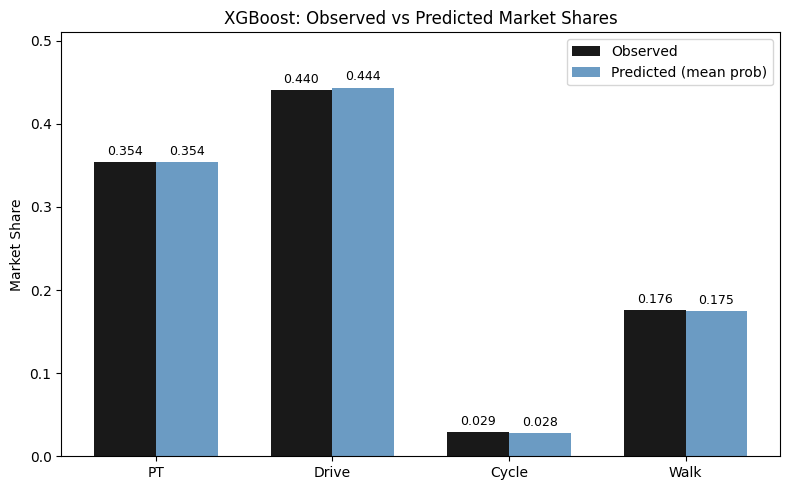

In [65]:
proba = best_xgb.predict_proba(X_test)
pred_shares = pd.Series(proba.mean(axis=0), index=best_xgb.classes_)
true_shares = pd.Series(y_test).value_counts(normalize=True).reindex(best_xgb.classes_)

print("True shares:\n", true_shares)
print("Predicted shares (probability mean):\n", pred_shares)

# Bar plot: observed vs predicted (mean probability) market shares
class_labels = [target_names[int(c)] for c in best_xgb.classes_]
observed = true_shares.reindex(best_xgb.classes_).fillna(0).values
predicted = pred_shares.reindex(best_xgb.classes_).fillna(0).values

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_obs = ax.bar(x - width/2, observed, width, label='Observed', color='black', alpha=0.9)
bars_pred = ax.bar(x + width/2, predicted, width, label='Predicted (mean prob)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylabel('Market Share')
ax.set_title('XGBoost: Observed vs Predicted Market Shares')
ax.legend()
ax.set_ylim(0, max(observed.max(), predicted.max()) * 1.15)

for bars in (bars_obs, bars_pred):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [40]:
bike_label = 2  
bike_col = np.where(xgb_model.classes_ == bike_label)[0][0]

# average predicted bike probability overall and on true-bike rows
p_bike_overall = proba[:, bike_col].mean()
p_bike_on_true_bike = proba[np.array(y_test)==bike_label, bike_col].mean()

print("Mean P(bike) overall:", p_bike_overall)
print("Mean P(bike) on true-bike cases:", p_bike_on_true_bike)


Mean P(bike) overall: 0.027711278
Mean P(bike) on true-bike cases: 0.10902476



XGBOOST MODEL EVALUATION

Prediction accuracy (weighted if applicable): 0.791


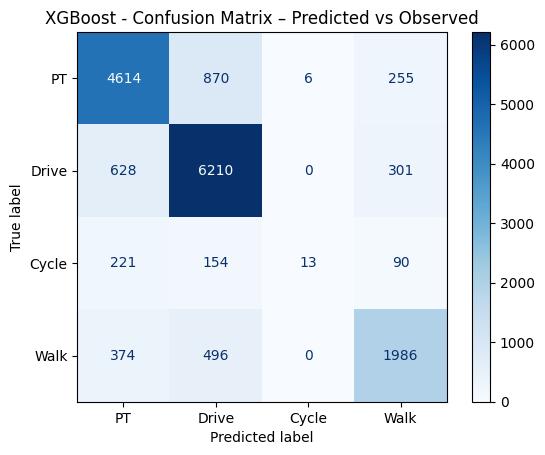


Per-class Accuracy (Recall):
PT: 0.8031 (4614.0/5745.0)
Drive: 0.8699 (6210.0/7139.0)
Cycle: 0.0272 (13.0/478.0)
Walk: 0.6954 (1986.0/2856.0)

F1 SCORES

Per-class F1 Scores:
  PT      : 0.7968
  Drive   : 0.8353
  Cycle   : 0.0523
  Walk    : 0.7238

Macro Average F1 Score: 0.6020

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          PT       0.79      0.80      0.80      5745
       Drive       0.80      0.87      0.84      7139
       Cycle       0.68      0.03      0.05       478
        Walk       0.75      0.70      0.72      2856

    accuracy                           0.79     16218
   macro avg       0.76      0.60      0.60     16218
weighted avg       0.79      0.79      0.78     16218



In [66]:
# ---------------------------------------------------------------
# XGBoost - Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
# Get predicted classes for XGBoost
y_pred_xgb_idx = y_pred_xgb

# Use same weights as other models
w = np.ones(len(y_test))
w_sum = w.sum()

acc_weighted_xgb = (w * (y_pred_xgb_idx == y_test)).sum() / w_sum
print(f"\n{'='*60}")
print("XGBOOST MODEL EVALUATION")
print(f"{'='*60}")
print(f"\nPrediction accuracy (weighted if applicable): {acc_weighted_xgb:.3f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb_idx, labels=[0, 1, 2, 3], sample_weight=w)
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=['PT', 'Drive', 'Cycle', 'Walk'])
disp_xgb.plot(cmap='Blues', values_format='.0f')
plt.title("XGBoost - Confusion Matrix – Predicted vs Observed")
plt.show()

# Calculate per-class accuracy (recall)
print("\nPer-class Accuracy (Recall):")
for i, mode in enumerate(['PT', 'Drive', 'Cycle', 'Walk']):
    class_accuracy = cm_xgb[i, i] / cm_xgb[i, :].sum()
    print(f"{mode}: {class_accuracy:.4f} ({cm_xgb[i, i]}/{cm_xgb[i, :].sum()})")

# ---------------------------------------------------------------
# F1 Scores (Per-class and Macro Average)
# ---------------------------------------------------------------
from sklearn.metrics import f1_score, classification_report

target_names = ['PT', 'Drive', 'Cycle', 'Walk']

# Calculate per-class F1 scores
f1_per_class = f1_score(y_test, y_pred_xgb_idx, average=None, labels=[0, 1, 2, 3])

# Calculate macro average F1 score
macro_f1 = f1_score(y_test, y_pred_xgb_idx, average='macro')

print("\n" + "="*60)
print("F1 SCORES")
print("="*60)
print("\nPer-class F1 Scores:")
for i, (mode, f1) in enumerate(zip(target_names, f1_per_class)):
    print(f"  {mode:8s}: {f1:.4f}")

print(f"\nMacro Average F1 Score: {macro_f1:.4f}")

# Full classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_xgb_idx, target_names=target_names))

#### XGBoost: Grid Search Convergence (Accuracy)

Visualize how the Grid Search Convergence using an Accuracy metric impact market share predictions.

In [63]:
import xgboost as xgb
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score

# XGBoost model with best parameters from Bayesian Optimization
print(f"\n{'='*60}")
print("XGBOOST - BEST MODEL (From Grid Search)")
print(f"{'='*60}")

# Best parameters from Bayesian optimization
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 15,
    'n_estimators': 300,
    'subsample': 0.8,
}

print("\nBest XGBoost parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Determine number of classes
n_classes = len(np.unique(y_train))

# Create XGBoost model with best parameters
xgb_model = xgb.XGBClassifier(
    random_state=0,
    verbosity=0,
    n_jobs=-1,
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    **best_params
)

print("\nTraining XGBoost with best parameters...")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb_acc = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Calculate Negative Log-Likelihood (NLL)
test_nll = log_loss(y_test, y_pred_proba_xgb, labels=best_xgb.classes_)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"\nNegative Log-Likelihood (NLL): {test_nll:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_xgb_acc):.4f}")

print("\nXGBoost Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_acc))

# Update best_xgb variable for downstream cells
best_xgb_acc = xgb_model


XGBOOST - BEST MODEL (From Grid Search)

Best XGBoost parameters:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 15
  n_estimators: 300
  subsample: 0.8

Training XGBoost with best parameters...

EVALUATION METRICS

Negative Log-Likelihood (NLL): 0.5166
Test Accuracy: 0.8276

XGBoost Results:
Confusion Matrix:
[[4794  721    4  226]
 [ 511 6393    2  233]
 [ 201  135   58   84]
 [ 302  375    2 2177]]


True shares:
 0    0.354236
1    0.440190
2    0.029473
3    0.176101
Name: proportion, dtype: float64
Predicted shares (probability mean):
 0    0.358553
1    0.461801
2    0.009284
3    0.170359
dtype: float32


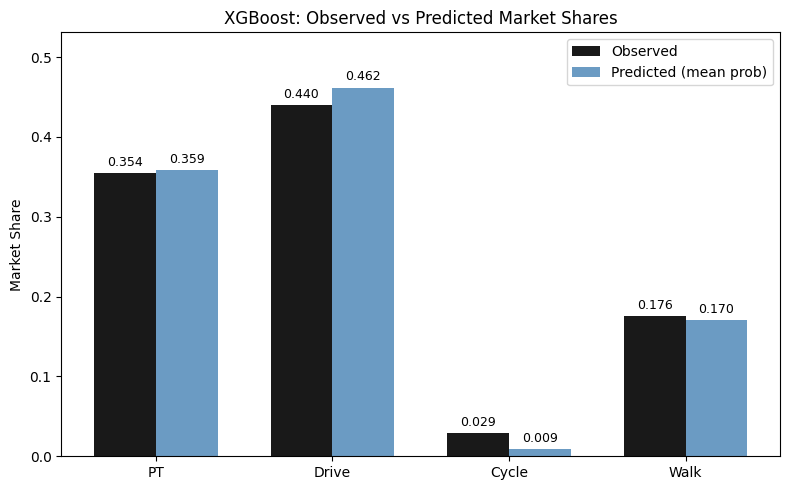

In [59]:
proba = best_xgb_acc.predict_proba(X_test)
pred_shares = pd.Series(proba.mean(axis=0), index=xgb_model.classes_)
true_shares = pd.Series(y_test).value_counts(normalize=True).reindex(xgb_model.classes_)

print("True shares:\n", true_shares)
print("Predicted shares (probability mean):\n", pred_shares)

# Bar plot: observed vs predicted (mean probability) market shares
class_labels = [target_names[int(c)] for c in xgb_model.classes_]
observed = true_shares.reindex(xgb_model.classes_).fillna(0).values
predicted = pred_shares.reindex(xgb_model.classes_).fillna(0).values

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_obs = ax.bar(x - width/2, observed, width, label='Observed', color='black', alpha=0.9)
bars_pred = ax.bar(x + width/2, predicted, width, label='Predicted (mean prob)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylabel('Market Share')
ax.set_title('XGBoost: Observed vs Predicted Market Shares')
ax.legend()
ax.set_ylim(0, max(observed.max(), predicted.max()) * 1.15)

for bars in (bars_obs, bars_pred):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()




XGBOOST MODEL EVALUATION

Prediction accuracy (weighted if applicable): 0.828


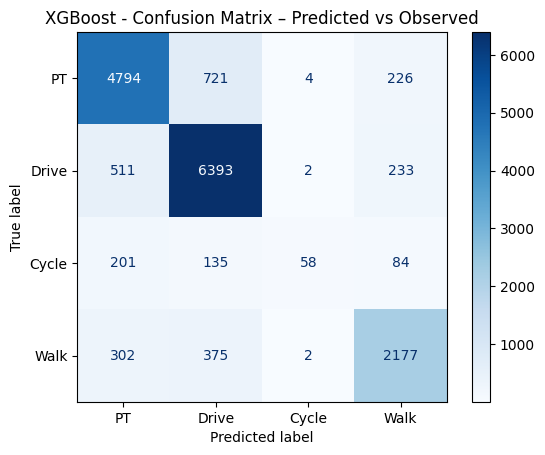


Per-class Accuracy (Recall):
PT: 0.8345 (4794.0/5745.0)
Drive: 0.8955 (6393.0/7139.0)
Cycle: 0.1213 (58.0/478.0)
Walk: 0.7623 (2177.0/2856.0)

Weighted log-likelihood: -9481.546
Average weighted log-likelihood per obs: -0.5846


In [ ]:
# ---------------------------------------------------------------
# XGBoost - Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
# Get predicted classes for XGBoost
y_pred_xgb_idx = y_pred_xgb_acc

# Use same weights as other models
w = np.ones(len(y_test))
w_sum = w.sum()

acc_weighted_xgb = (w * (y_pred_xgb_idx == y_test)).sum() / w_sum
print(f"\n{'='*60}")
print("XGBOOST MODEL EVALUATION")
print(f"{'='*60}")
print(f"\nPrediction accuracy (weighted if applicable): {acc_weighted_xgb:.3f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb_idx, labels=[0, 1, 2, 3], sample_weight=w)
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=['PT', 'Drive', 'Cycle', 'Walk'])
disp_xgb.plot(cmap='Blues', values_format='.0f')
plt.title("XGBoost - Confusion Matrix – Predicted vs Observed")
plt.show()

# Calculate per-class accuracy (recall)
print("\nPer-class Accuracy (Recall):")
for i, mode in enumerate(['PT', 'Drive', 'Cycle', 'Walk']):
    class_accuracy = cm_xgb[i, i] / cm_xgb[i, :].sum()
    print(f"{mode}: {class_accuracy:.4f} ({cm_xgb[i, i]}/{cm_xgb[i, :].sum()})")

# ---------------------------------------------------------------
# Weighted log-likelihood for XGBoost
# ---------------------------------------------------------------
# Get probability for the chosen class for each observation
probs_xgb = best_xgb.predict_proba(X_test)
prob_chosen_xgb = probs_xgb[np.arange(len(y_test)), y_test]
prob_chosen_xgb = np.clip(prob_chosen_xgb, 1e-300, 1)
LL_xgb = np.sum(w * np.log(prob_chosen_xgb))
avg_LL_xgb = LL_xgb / w_sum
print(f"\nWeighted log-likelihood: {LL_xgb:.3f}")
print(f"Average weighted log-likelihood per obs: {avg_LL_xgb:.4f}")

## 6. Scenario Analysis and Counterfactuals

Analyze how transport mode choices would change under different scenarios such as driving cost increases or PT service improvements.

In [60]:
import os

# ==============================================================================
# SCENARIO ANALYSIS: DRIVING COST & TIME (COUNTERFACTUAL) - XGBoost
# ==============================================================================
# Effect 1: Increase driving cost (cost_driving_total) by +10%, +20%, +30%
# Effect 2: Increase driving time (dur_driving) by +2%, +5%, +8% (scaled 1:5 with cost)
# ==============================================================================

# Get feature indices
feature_names_list = selected_data.drop(['travel_mode'], axis=1).columns.tolist()
cost_idx = feature_names_list.index('cost_driving_total')
time_idx = feature_names_list.index('dur_driving')

# Define scenarios
cost_increases = [0.10, 0.20, 0.30]
time_increases = [0.02, 0.05, 0.08]

# Get baseline predictions using XGBoost
probs_baseline = best_xgb.predict_proba(X_test)
baseline_market_share = probs_baseline.mean(axis=0)

# Create summary table data
summary_data = []
baseline_row = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share[0]:.4f}",
    'Drive': f"{baseline_market_share[1]:.4f}",
    'Cycle': f"{baseline_market_share[2]:.4f}",
    'Walk': f"{baseline_market_share[3]:.4f}"
}
summary_data.append(baseline_row)

# Run scenarios
scenario_names = [
    'Cost +10%, Time +2%',
    'Cost +20%, Time +5%',
    'Cost +30%, Time +8%'
]

for cost_increase, time_increase, scenario_name in zip(cost_increases, time_increases, scenario_names):
    # Create counterfactual data
    X_scenario = X_test.copy().astype(float)
    X_scenario[:, cost_idx] = X_scenario[:, cost_idx] * (1 + cost_increase)
    X_scenario[:, time_idx] = X_scenario[:, time_idx] * (1 + time_increase)
    
    # Get predictions
    probs_scenario = best_xgb.predict_proba(X_scenario)
    market_share_scenario = probs_scenario.mean(axis=0)
    
    # Add to summary
    summary_data.append({
        'Scenario': scenario_name,
        'PT': f"{market_share_scenario[0]:.4f}",
        'Drive': f"{market_share_scenario[1]:.4f}",
        'Cycle': f"{market_share_scenario[2]:.4f}",
        'Walk': f"{market_share_scenario[3]:.4f}"
    })

# Display summary table
print("\n" + "="*80)
print("DRIVING COST & TIME SCENARIO ANALYSIS - XGBoost (Counterfactual)")
print("="*80)
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Export summary table to Excel
summary_df.to_excel('scenario_analysis_xgboost.xlsx', index=False, sheet_name='Driving Cost Scenarios')
print("\nSummary table exported to 'scenario_analysis_xgboost.xlsx'")
print("Excel file saved at:", os.path.abspath('scenario_analysis_xgboost.xlsx'))




DRIVING COST & TIME SCENARIO ANALYSIS - XGBoost (Counterfactual)
           Scenario     PT  Drive  Cycle   Walk
           Baseline 0.3541 0.4436 0.0277 0.1745
Cost +10%, Time +2% 0.3584 0.4425 0.0270 0.1721
Cost +20%, Time +5% 0.3622 0.4408 0.0267 0.1703
Cost +30%, Time +8% 0.3656 0.4385 0.0266 0.1693

Summary table exported to 'scenario_analysis_xgboost.xlsx'
Excel file saved at: c:\Users\crist\Documents\Cristian\Advanced Data Analysis Code\Random Forest\scenario_analysis_xgboost.xlsx


In [141]:
# ==============================================================================
# SCENARIO ANALYSIS: PT SERVICE IMPROVEMENT (COUNTERFACTUAL) - XGBoost
# ==============================================================================
# Effect 1: Reduce PT access and waiting times by −10%, −20%, −30%
# Effect 2: Reduce transfer penalty index by −10%, −20%, −30%
# ==============================================================================

# Get feature indices for PT features
feature_names_list = selected_data.drop(['travel_mode'], axis=1).columns.tolist()
pt_access_idx = feature_names_list.index('dur_pt_access')
pt_wait_idx = feature_names_list.index('dur_pt_int_waiting')
pt_penalty_idx = feature_names_list.index('pt_penalty_index')

# Define PT scenarios
pt_scenarios = [
    ('PT Access/Wait -10% / Penalty -10%', -0.10, -0.10),
    ('PT Access/Wait -20% / Penalty -20%', -0.20, -0.20),
    ('PT Access/Wait -30% / Penalty -30%', -0.30, -0.30),
]

# Get baseline predictions using XGBoost
probs_baseline_pt = best_xgb.predict_proba(X_test)
baseline_market_share_pt = probs_baseline_pt.mean(axis=0)

# Create summary table data
summary_data_pt = []
baseline_row_pt = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share_pt[0]:.4f}",
    'Drive': f"{baseline_market_share_pt[1]:.4f}",
    'Cycle': f"{baseline_market_share_pt[2]:.4f}",
    'Walk': f"{baseline_market_share_pt[3]:.4f}"
}
summary_data_pt.append(baseline_row_pt)

# Run PT scenarios
for scenario_name, time_reduction, transfer_reduction in pt_scenarios:
    # Create counterfactual data
    X_scenario_pt = X_test.copy().astype(float)
    X_scenario_pt[:, pt_access_idx] = X_scenario_pt[:, pt_access_idx] * (1 + time_reduction)
    X_scenario_pt[:, pt_wait_idx] = X_scenario_pt[:, pt_wait_idx] * (1 + time_reduction)
    X_scenario_pt[:, pt_penalty_idx] = X_scenario_pt[:, pt_penalty_idx] * (1 + transfer_reduction)
    
    # Get predictions
    probs_scenario_pt = best_xgb.predict_proba(X_scenario_pt)
    market_share_scenario_pt = probs_scenario_pt.mean(axis=0)
    
    # Add to summary
    summary_data_pt.append({
        'Scenario': scenario_name,
        'PT': f"{market_share_scenario_pt[0]:.4f}",
        'Drive': f"{market_share_scenario_pt[1]:.4f}",
        'Cycle': f"{market_share_scenario_pt[2]:.4f}",
        'Walk': f"{market_share_scenario_pt[3]:.4f}"
    })

# Display summary table
print("\n" + "="*80)
print("PT SERVICE IMPROVEMENT SCENARIO ANALYSIS - XGBoost (Counterfactual)")
print("="*80)
summary_df_pt = pd.DataFrame(summary_data_pt)
print(summary_df_pt.to_string(index=False))

# Export summary table to Excel
summary_df_pt.to_excel('scenario_analysis_pt_xgboost.xlsx', index=False, sheet_name='PT Service Scenarios')
print("\nSummary table exported to 'scenario_analysis_pt_xgboost.xlsx'")
print("Excel file saved at:", os.path.abspath('scenario_analysis_pt_xgboost.xlsx'))



PT SERVICE IMPROVEMENT SCENARIO ANALYSIS - XGBoost (Counterfactual)
                          Scenario     PT  Drive  Cycle   Walk
                          Baseline 0.3541 0.4436 0.0277 0.1745
PT Access/Wait -10% / Penalty -10% 0.3647 0.4354 0.0267 0.1732
PT Access/Wait -20% / Penalty -20% 0.3752 0.4272 0.0256 0.1719
PT Access/Wait -30% / Penalty -30% 0.3857 0.4191 0.0246 0.1706

Summary table exported to 'scenario_analysis_pt_xgboost.xlsx'
Excel file saved at: c:\Users\crist\Documents\Cristian\Advanced Data Analysis Code\Random Forest\scenario_analysis_pt_xgboost.xlsx


## 7. Feature Effects and Partial Dependence Analysis

Visualize how individual features affect the probability of each transport mode choice for the XGBoost model.

PARTIAL DEPENDENCE PLOTS (PDP) - XGBOOST MODEL

Generating PDPs for 10 features...
Features: ['distance', 'dur_driving', 'dur_pt_total', 'dur_cycling', 'dur_walking', 'cost_driving_total', 'cost_transit', 'age', 'car_ownership', 'driving_license']

Generating PDP for class: PT


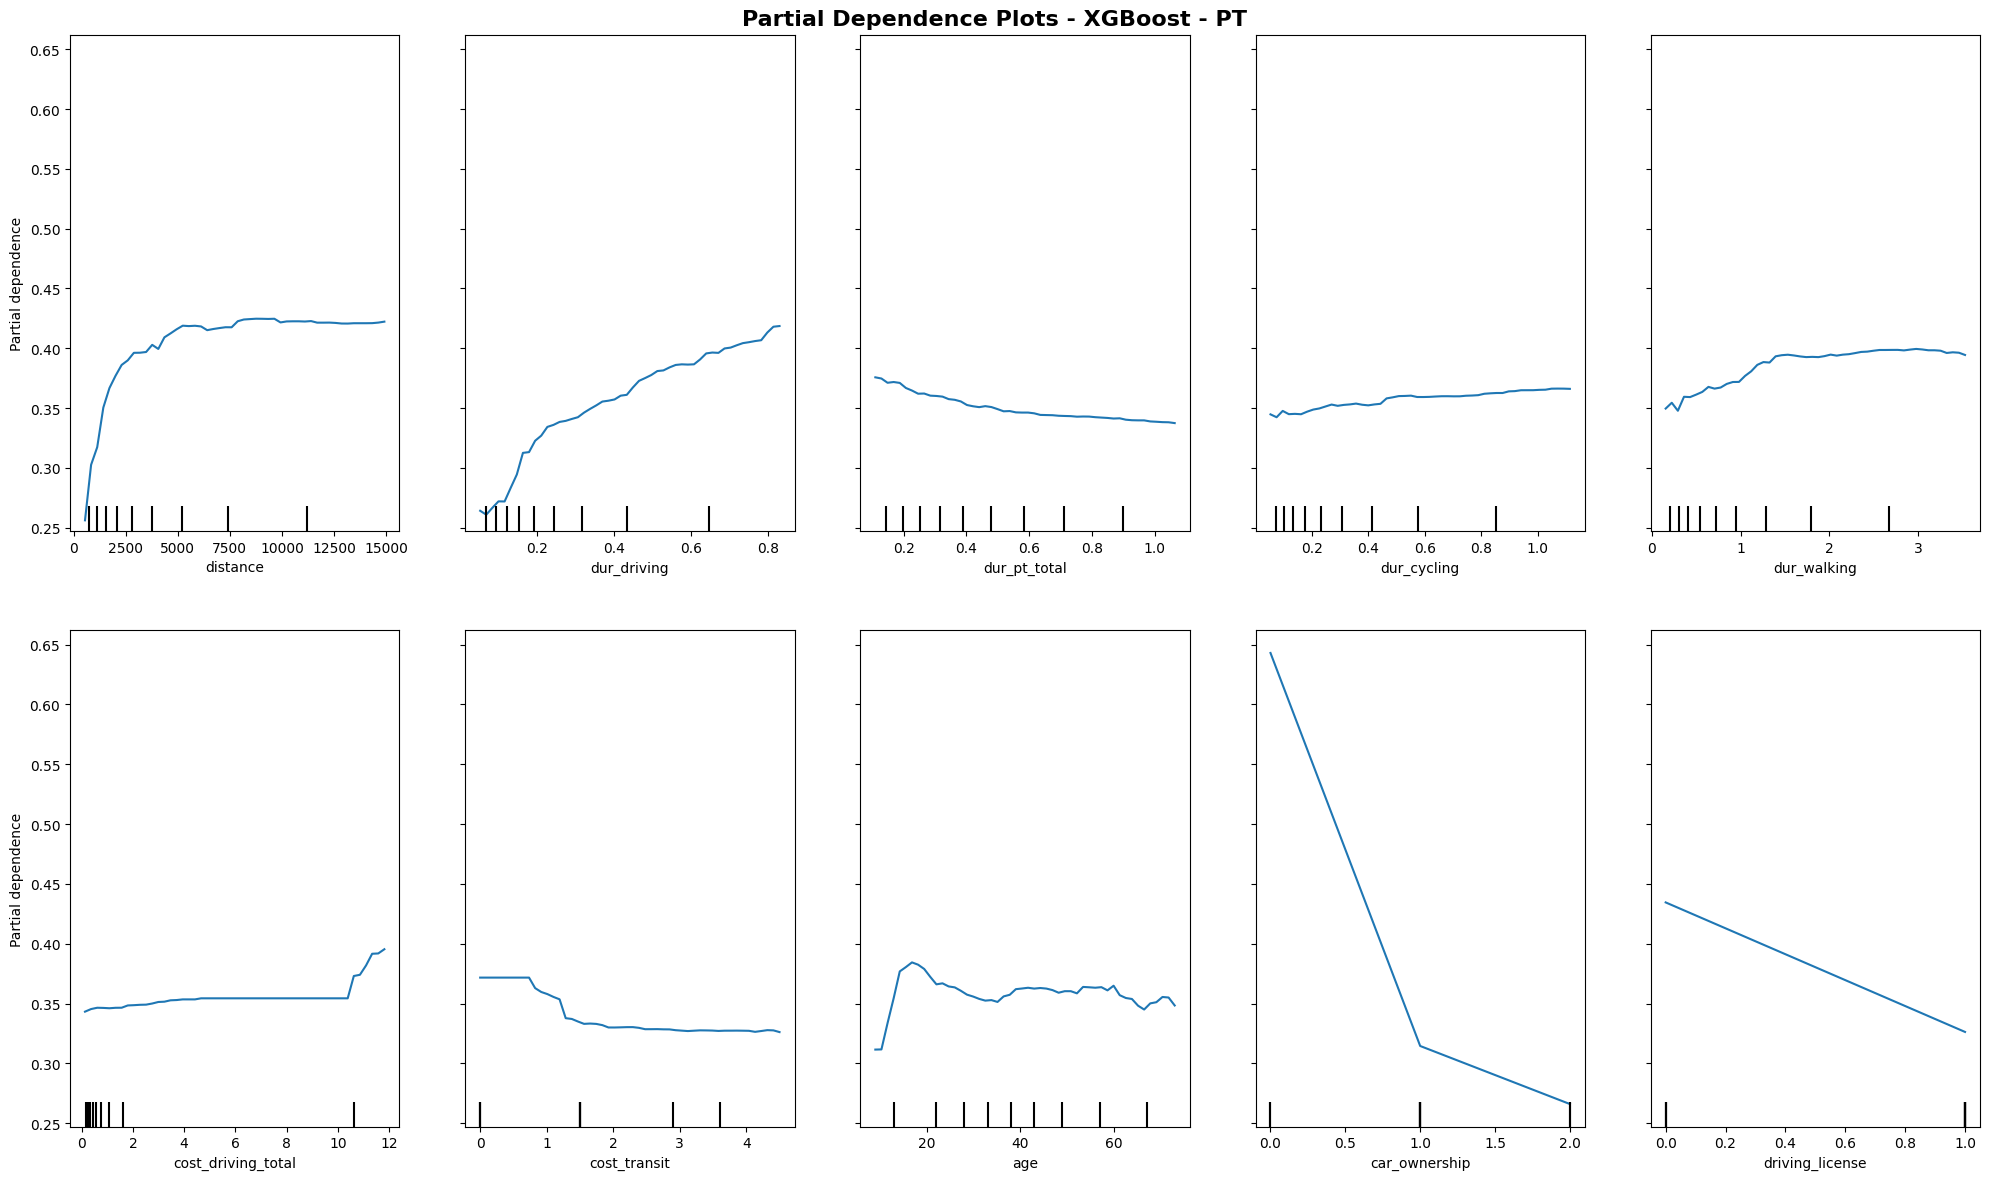


Generating PDP for class: Drive


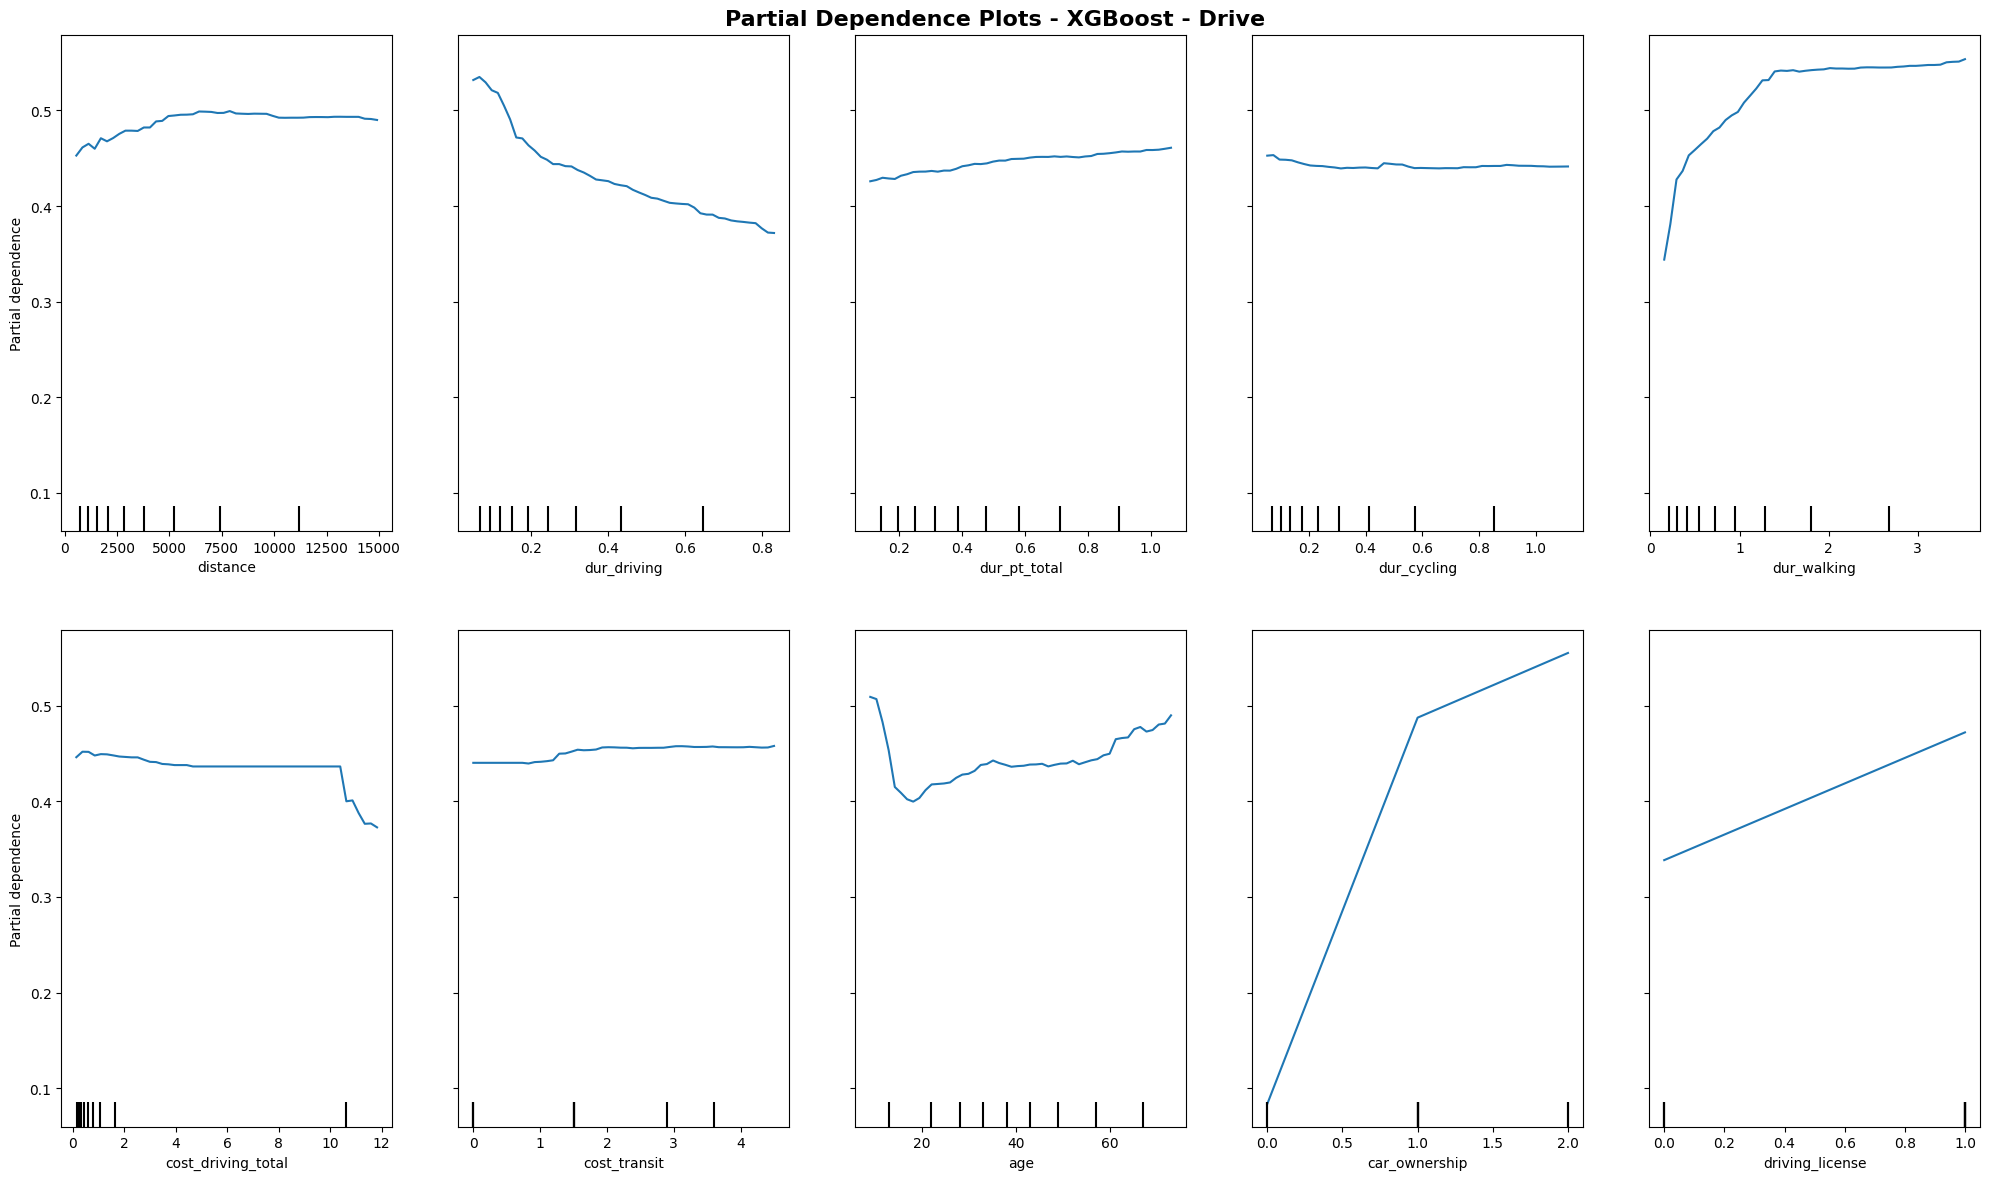


Generating PDP for class: Cycle


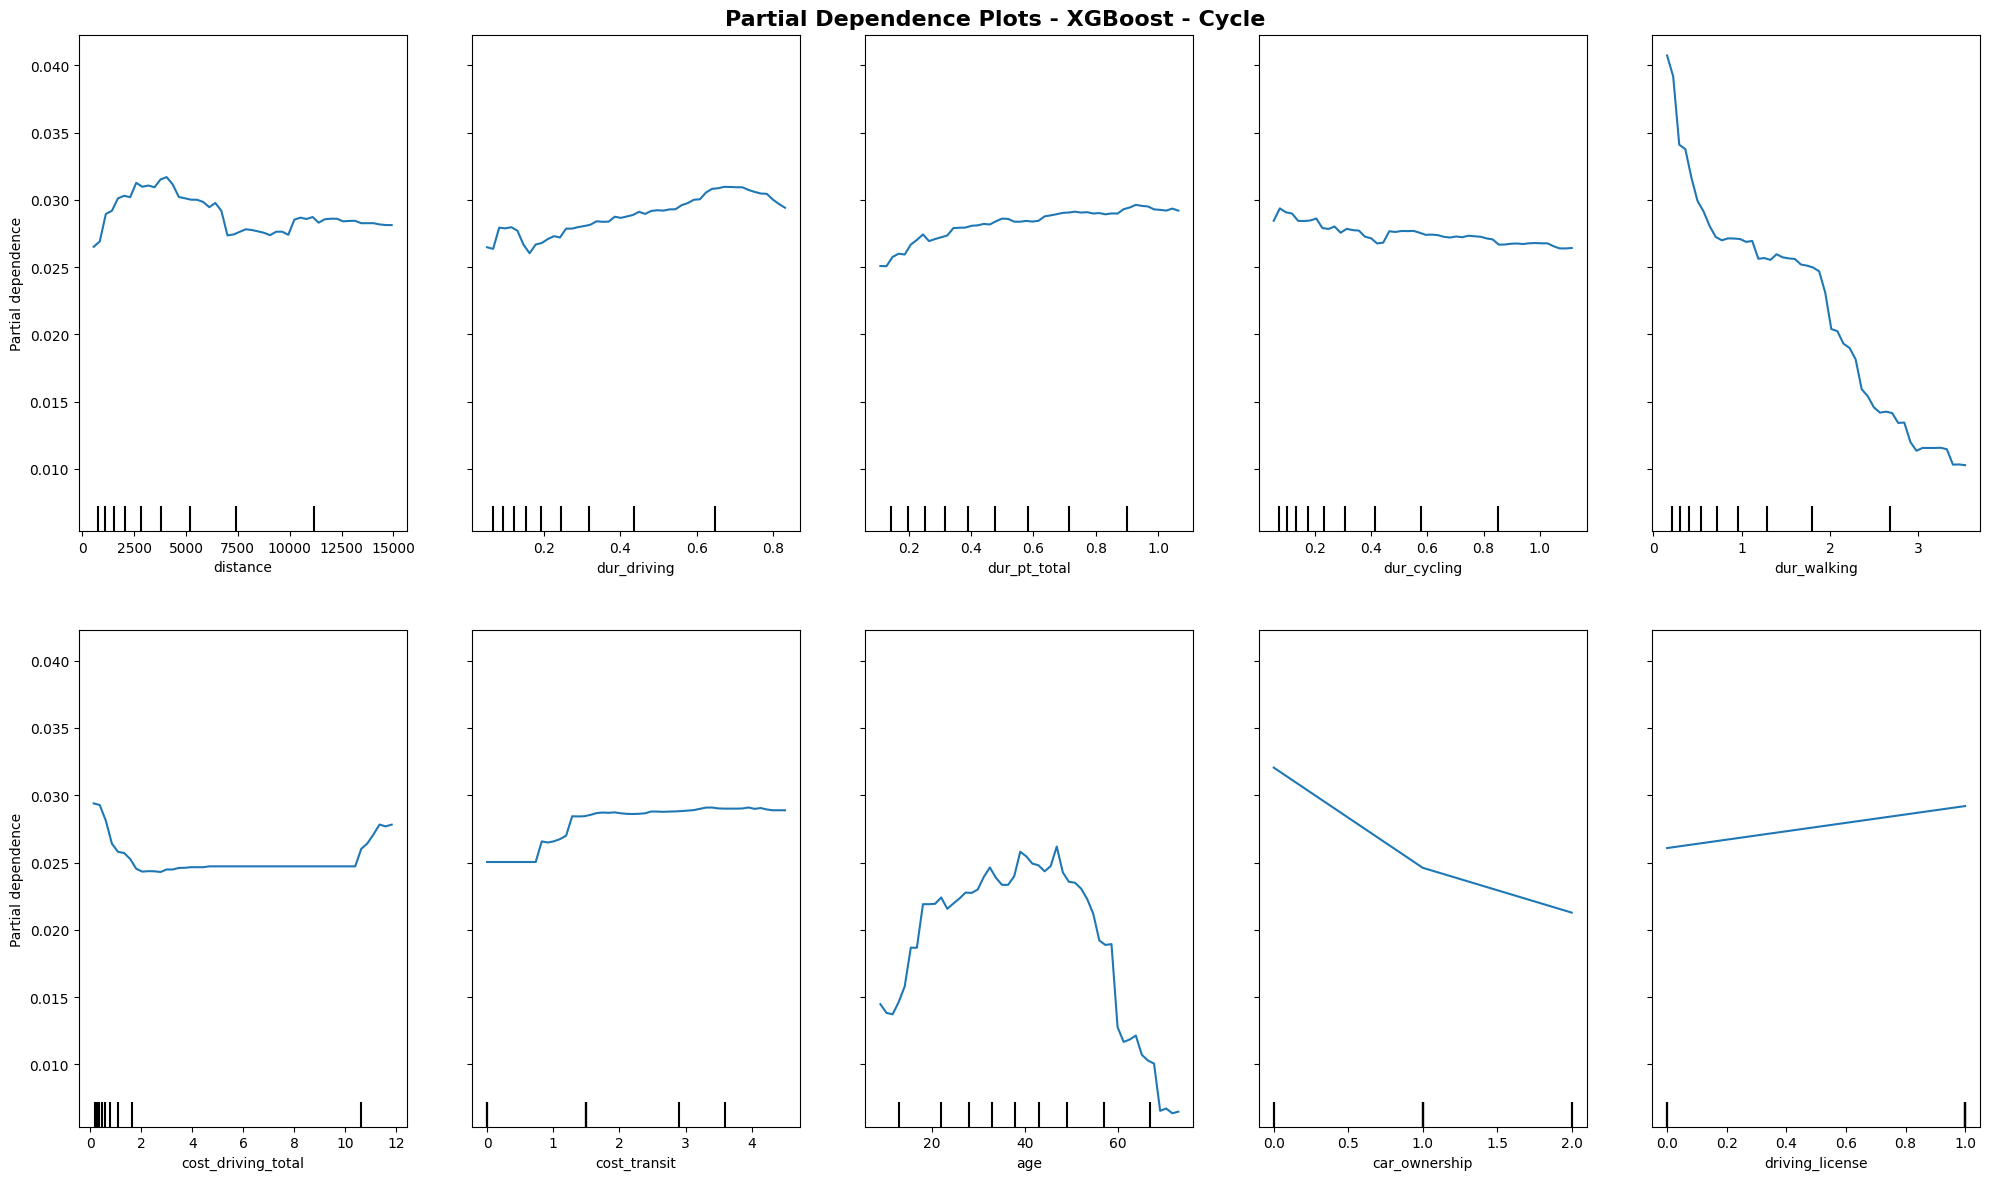


Generating PDP for class: Walk


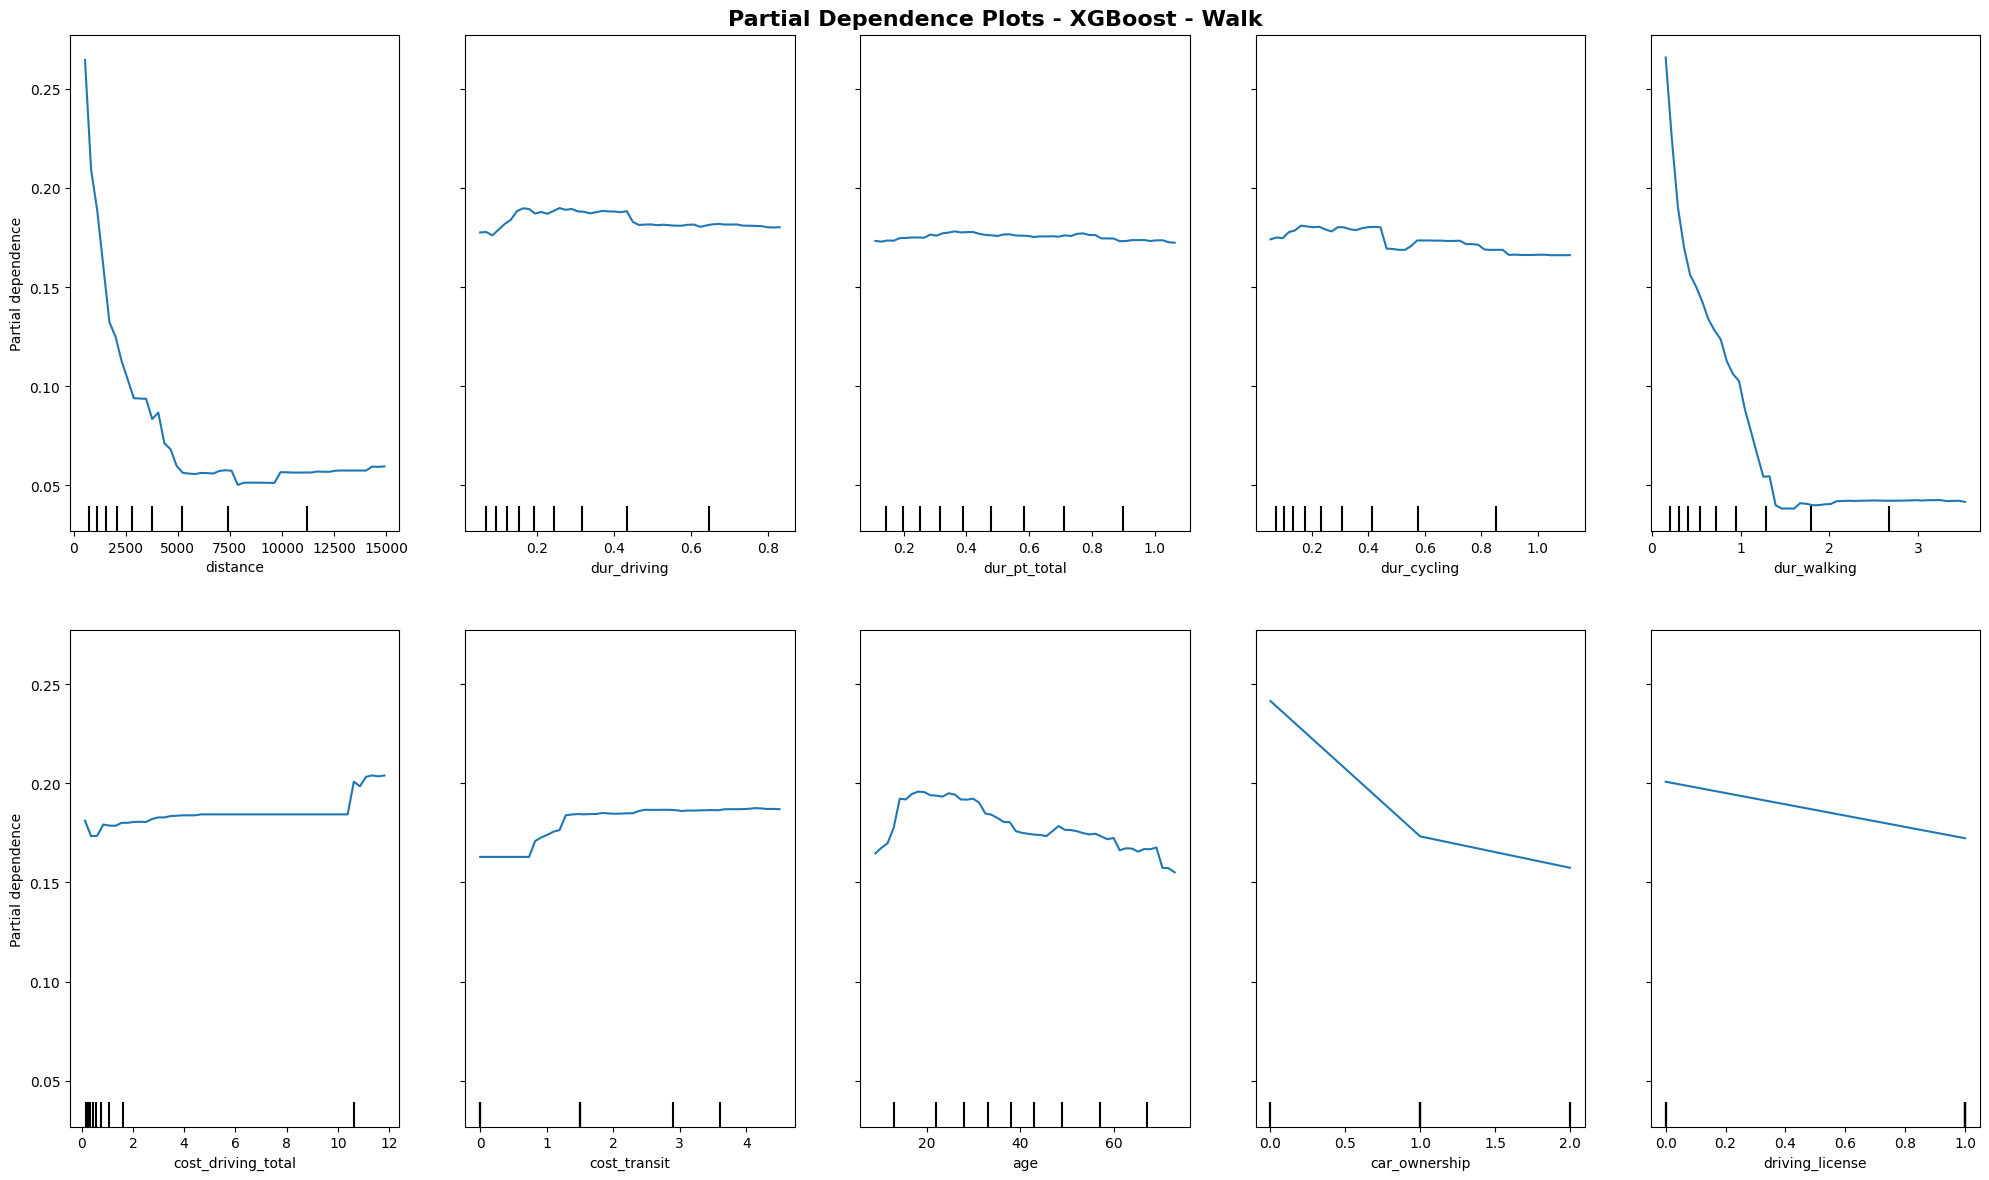


PDP generation complete!


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get feature names
feature_names_list = selected_data.drop(['travel_mode'], axis=1).columns.tolist()

# Select important features for PDP (top 10 from feature importance or specific features of interest)
# You can adjust this list based on your analysis needs
important_features = [
    'distance', 'dur_driving', 'dur_pt_total', 'dur_cycling', 'dur_walking',
    'cost_driving_total', 'cost_transit', 'age', 'car_ownership', 'driving_license'
]

# Get feature indices
feature_indices = [feature_names_list.index(f) for f in important_features if f in feature_names_list]

print("="*80)
print("PARTIAL DEPENDENCE PLOTS (PDP) - XGBOOST MODEL")
print("="*80)
print(f"\nGenerating PDPs for {len(feature_indices)} features...")
print(f"Features: {[feature_names_list[i] for i in feature_indices]}")

# Create PDPs for each transport mode (class)
target_names = ['PT', 'Drive', 'Cycle', 'Walk']

for class_idx, class_name in enumerate(target_names):
    print(f"\nGenerating PDP for class: {class_name}")
    
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Create partial dependence display
    display = PartialDependenceDisplay.from_estimator(
        best_xgb,
        X_train,
        features=feature_indices,
        feature_names=feature_names_list,
        target=class_idx,
        n_cols=5,
        grid_resolution=50,
        ax=ax,
        kind='average'
    )
    
    fig.suptitle(f'Partial Dependence Plots - XGBoost - {class_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("PDP generation complete!")
print("="*80)

## 8. Comparative Model Analysis

Compare performance across all models using F1 scores, accuracy, and market share predictions.

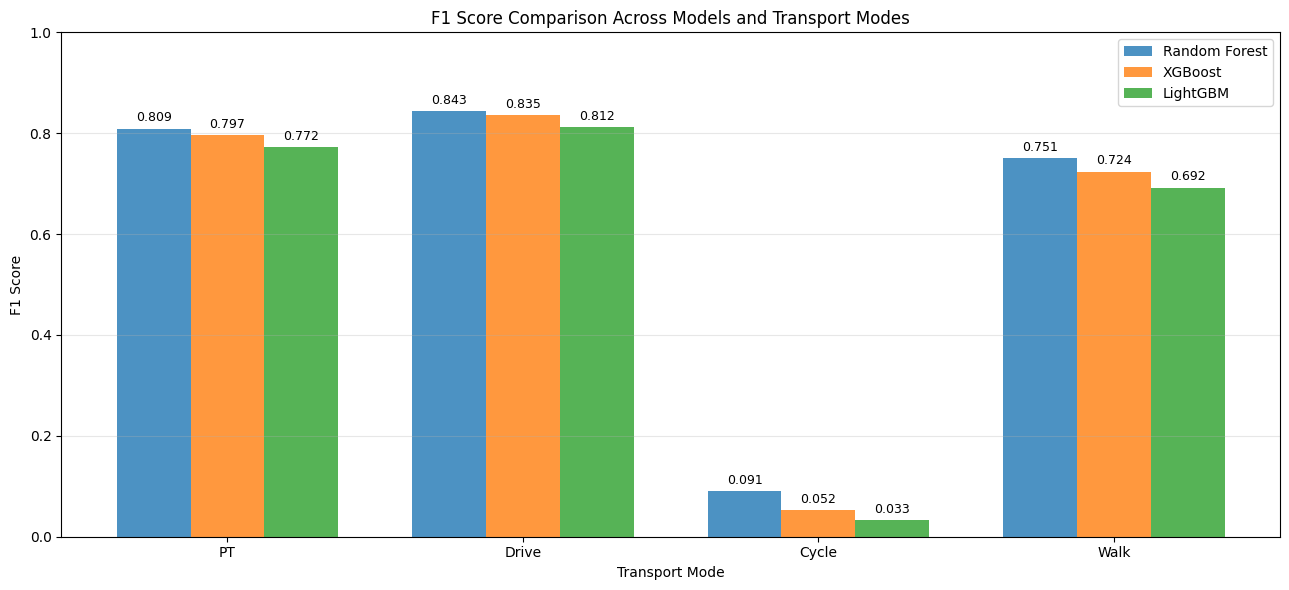

F1 Scores by Model and Transport Mode:
------------------------------------------------------------
PT    : RF=0.809, XGB=0.797, LGB=0.772
Drive : RF=0.843, XGB=0.835, LGB=0.812
Cycle : RF=0.091, XGB=0.052, LGB=0.033
Walk  : RF=0.751, XGB=0.724, LGB=0.692

DETAILED F1 SCORES PER CLASS - XGBOOST

Classification Report (XGBoost):
              precision    recall  f1-score   support

          PT       0.79      0.80      0.80      5745
       Drive       0.80      0.87      0.84      7139
       Cycle       0.68      0.03      0.05       478
        Walk       0.75      0.70      0.72      2856

    accuracy                           0.79     16218
   macro avg       0.76      0.60      0.60     16218
weighted avg       0.79      0.79      0.78     16218


F1 SCORE SUMMARY TABLE - ALL MODELS
Transport Mode  Random Forest  XGBoost  LightGBM
            PT       0.809010 0.796754  0.772401
         Drive       0.843225 0.835295  0.812044
         Cycle       0.091270 0.052314  0.032587
  

In [67]:
import numpy as np
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# Get classification reports for all models

# Define target names
target_names = ['PT', 'Drive', 'Cycle', 'Walk']

# Get F1 scores for each model
def get_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    return [report[name]['f1-score'] for name in target_names]

# Calculate F1 scores for all models
f1_rf = get_f1_scores(y_test, y_predicted_tuned)
f1_xgb = get_f1_scores(y_test, y_pred_xgb)
f1_lgb = get_f1_scores(y_test, y_pred_lgb)

# Create the plot
x = np.arange(len(target_names))
width = 0.25

fig, ax = plt.subplots(figsize=(13, 6))
bars1 = ax.bar(x - width, f1_rf, width, label='Random Forest', alpha=0.8)
bars2 = ax.bar(x, f1_xgb, width, label='XGBoost', alpha=0.8)
bars3 = ax.bar(x + width, f1_lgb, width, label='LightGBM', alpha=0.8)

# Customize the plot
ax.set_xlabel('Transport Mode')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison Across Models and Transport Modes')
ax.set_xticks(x)
ax.set_xticklabels(target_names)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print numerical values
print("F1 Scores by Model and Transport Mode:")
print("-" * 60)
for i, mode in enumerate(target_names):
    print(f"{mode:6}: RF={f1_rf[i]:.3f}, XGB={f1_xgb[i]:.3f}, LGB={f1_lgb[i]:.3f}")

# Print detailed classification reports for XGBoost
print("\n" + "="*80)
print("DETAILED F1 SCORES PER CLASS - XGBOOST")
print("="*80)
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

print("\n" + "="*80)
print("F1 SCORE SUMMARY TABLE - ALL MODELS")
print("="*80)
f1_summary = pd.DataFrame({
    'Transport Mode': target_names,
    'Random Forest': f1_rf,
    'XGBoost': f1_xgb,
    'LightGBM': f1_lgb
})
print(f1_summary.to_string(index=False))

# Calculate macro F1 scores and accuracies for all models
from sklearn.metrics import f1_score, accuracy_score

macro_f1_rf = f1_score(y_test, y_predicted_tuned, average='macro')
macro_f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
macro_f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')

acc_rf = accuracy_score(y_test, y_predicted_tuned)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("\n" + "="*80)
print("OVERALL MODEL PERFORMANCE METRICS")
print("="*80)
performance_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [acc_rf, acc_xgb, acc_lgb],
    'Macro F1': [macro_f1_rf, macro_f1_xgb, macro_f1_lgb]
})
print(performance_summary.to_string(index=False))

print("\n" + "="*80)
print("MODEL RANKING BY PERFORMANCE")
print("="*80)
print("\nBy Accuracy:")
print(performance_summary.sort_values('Accuracy', ascending=False)[['Model', 'Accuracy']].to_string(index=False))
print("\nBy Macro F1 Score:")
print(performance_summary.sort_values('Macro F1', ascending=False)[['Model', 'Macro F1']].to_string(index=False))

# Export the F1 score summary table to Excel
f1_summary.to_excel('f1_scores_comparison.xlsx', index=False)
performance_summary.to_excel('model_performance_summary.xlsx', index=False)
print("\n" + "="*80)
print("F1 scores exported to 'f1_scores_comparison.xlsx'")
print("Overall performance metrics exported to 'model_performance_summary.xlsx'")

MARKET SHARE ANALYSIS - TEST SAMPLE

Observed Market Shares (Test Sample):
  PT      : 0.3542 (35.42%)
  Drive   : 0.4402 (44.02%)
  Cycle   : 0.0295 (2.95%)
  Walk    : 0.1761 (17.61%)

Random Forest - Predicted Market Shares (Mean Probability):
  PT      : 0.3522 (35.22%) | Diff: -0.0020 (-0.20%)
  Drive   : 0.4416 (44.16%) | Diff: +0.0014 (+0.14%)
  Cycle   : 0.0310 (3.10%) | Diff: +0.0015 (+0.15%)
  Walk    : 0.1752 (17.52%) | Diff: -0.0009 (-0.09%)

LightGBM - Predicted Market Shares (Mean Probability):
  PT      : 0.3545 (35.45%) | Diff: +0.0002 (+0.02%)
  Drive   : 0.4419 (44.19%) | Diff: +0.0018 (+0.18%)
  Cycle   : 0.0291 (2.91%) | Diff: -0.0003 (-0.03%)
  Walk    : 0.1744 (17.44%) | Diff: -0.0017 (-0.17%)

XGBoost - Predicted Market Shares (Mean Probability):
  PT      : 0.3541 (35.41%) | Diff: -0.0001 (-0.01%)
  Drive   : 0.4436 (44.36%) | Diff: +0.0034 (+0.34%)
  Cycle   : 0.0277 (2.77%) | Diff: -0.0018 (-0.18%)
  Walk    : 0.1745 (17.45%) | Diff: -0.0016 (-0.16%)

MARKET S

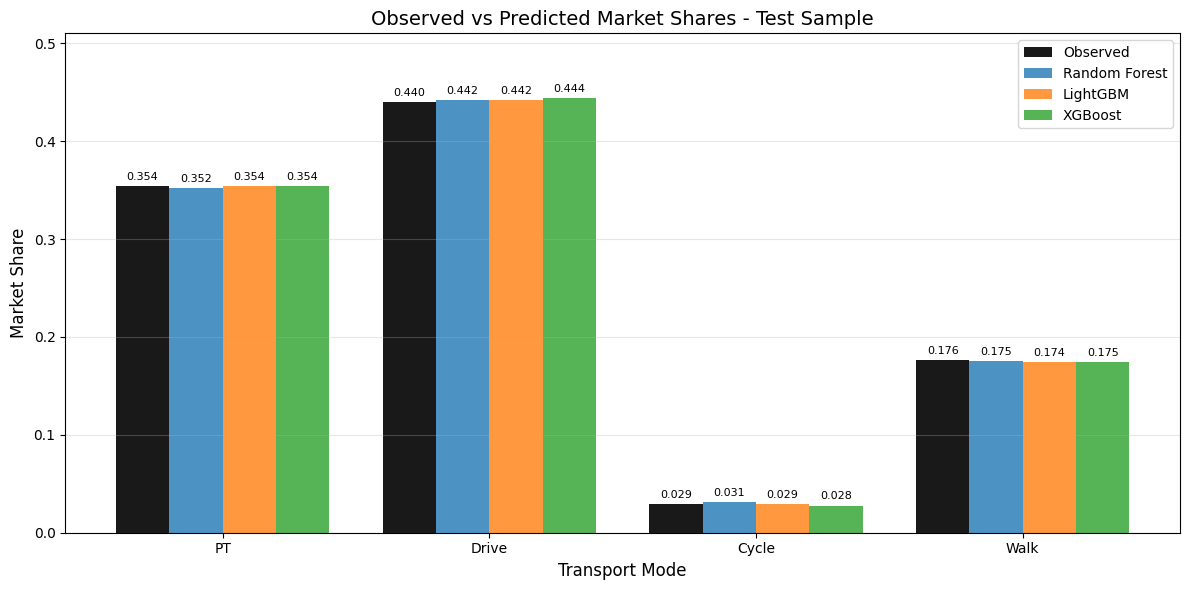

In [72]:
# Compute predicted and observed market shares for all models

print("="*80)
print("MARKET SHARE ANALYSIS - TEST SAMPLE")
print("="*80)

# Get probability predictions from all models
y_proba_dict = {
    'Random Forest': best_rf.predict_proba(X_test),
    'LightGBM': best_lgb.predict_proba(X_test),
    'XGBoost': best_xgb.predict_proba(X_test)
}

# Calculate observed market shares
observed_shares = pd.Series(y_test).value_counts(normalize=True).sort_index()
observed_shares_dict = {target_names[i]: observed_shares.get(i, 0) for i in range(4)}

print("\nObserved Market Shares (Test Sample):")
for mode, share in observed_shares_dict.items():
    print(f"  {mode:8s}: {share:.4f} ({share*100:.2f}%)")

# Calculate predicted market shares for each model (using mean probabilities)
market_share_results = {'Transport Mode': target_names, 'Observed': [observed_shares_dict[mode] for mode in target_names]}

for model_name, y_proba in y_proba_dict.items():
    # Market share = mean probability for each class across all test samples
    pred_shares_dict = {target_names[i]: y_proba[:, i].mean() for i in range(4)}
    
    print(f"\n{model_name} - Predicted Market Shares (Mean Probability):")
    for mode, share in pred_shares_dict.items():
        obs_share = observed_shares_dict[mode]
        diff = share - obs_share
        print(f"  {mode:8s}: {share:.4f} ({share*100:.2f}%) | Diff: {diff:+.4f} ({diff*100:+.2f}%)")
    
    market_share_results[model_name] = [pred_shares_dict[mode] for mode in target_names]

# Create comparison table
market_share_df = pd.DataFrame(market_share_results)

print("\n" + "="*80)
print("MARKET SHARE COMPARISON TABLE")
print("="*80)
print(market_share_df.to_string(index=False))

# Calculate absolute errors for each model
print("\n" + "="*80)
print("MARKET SHARE PREDICTION ERRORS (Absolute)")
print("="*80)
error_results = {'Transport Mode': target_names}
for model_name in y_proba_dict.keys():
    errors = [abs(market_share_df[market_share_df['Transport Mode'] == mode][model_name].values[0] - 
                  market_share_df[market_share_df['Transport Mode'] == mode]['Observed'].values[0]) 
              for mode in target_names]
    error_results[model_name] = errors
    mean_error = np.mean(errors)
    print(f"\n{model_name}:")
    for mode, err in zip(target_names, errors):
        print(f"  {mode:8s}: {err:.4f} ({err*100:.2f}%)")
    print(f"  Mean Absolute Error: {mean_error:.4f} ({mean_error*100:.2f}%)")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(target_names))
width = 0.2

bars1 = ax.bar(x - 1.5*width, market_share_df['Observed'], width, label='Observed', alpha=0.9, color='black')
bars2 = ax.bar(x - 0.5*width, market_share_df['Random Forest'], width, label='Random Forest', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, market_share_df['LightGBM'], width, label='LightGBM', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, market_share_df['XGBoost'], width, label='XGBoost', alpha=0.8)

ax.set_xlabel('Transport Mode', fontsize=12)
ax.set_ylabel('Market Share', fontsize=12)
ax.set_title('Observed vs Predicted Market Shares - Test Sample', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(target_names)
ax.legend()
ax.set_ylim(0, max(market_share_df['Observed'].max(), 
                    market_share_df['Random Forest'].max(),
                    market_share_df['LightGBM'].max(),
                    market_share_df['XGBoost'].max()) * 1.15)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
autolabel(bars4)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Create detailed error analysis DataFrame
error_analysis = pd.DataFrame({
    'Transport Mode': target_names,
    'Observed': [observed_shares_dict[mode] for mode in target_names],
    'Random Forest': [market_share_df[market_share_df['Transport Mode'] == mode]['Random Forest'].values[0] for mode in target_names],
    'LightGBM': [market_share_df[market_share_df['Transport Mode'] == mode]['LightGBM'].values[0] for mode in target_names],
    'XGBoost': [market_share_df[market_share_df['Transport Mode'] == mode]['XGBoost'].values[0] for mode in target_names],
    'RF Error': error_results['Random Forest'],
    'LGB Error': error_results['LightGBM'],
    'XGB Error': error_results['XGBoost']
})


## 9. SHAP Interpretability Analysis

Use SHAP (SHapley Additive exPlanations) to understand feature importance and model predictions across different models. SHAP values provide a unified approach to explaining predictions by calculating each feature's contribution to the model output based on cooperative game theory.

This section includes:
- **Global Feature Importance**: Which features matter most across all predictions
- **Local Explanations**: How features influence individual predictions
- **Feature Elasticity**: Quantifying the sensitivity of transport mode probabilities to feature changes
- **Model Comparisons**: SHAP analysis across LightGBM and XGBoost models

### 9.1 SHAP Interpretability for LightGBM

In [ ]:
import shap

import matplotlib.pyplot as plt

# Initialize the SHAP explainer for LightGBM
explainer = shap.TreeExplainer(best_lgb, model_output="probability", feature_perturbation="interventional", data=X_train)

# Calculate SHAP values for the test set (using a sample for performance)
sample_size = 1000  # Use a sample for faster computation
sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_test_sample = X_test[sample_indices]
X_test_sample_orig = X_test[sample_indices]

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_sample)

mode_labels = {0: 'pt', 1: 'drive', 2: 'cycle', 3: 'walk'}
# shap_values is a list with one array per output class
print(f"\nSHAP values computed for {len(shap_values)} classes")
print(f"Shape per class: {shap_values[0].shape}")
print(f"Sample ranges per class:")
for i, mode_name in mode_labels.items():
    print(f"  {mode_name}: [{np.min(shap_values[i]):.4f}, {np.max(shap_values[i]):.4f}]")


Calculating SHAP values...


100%|===================| 3997/4000 [12:37<00:00]        


SHAP values computed for 1000 classes
Shape per class: (36, 4)
Sample ranges per class:
  pt: [-0.1772, 0.1014]
  drive: [-0.1519, 0.3578]
  cycle: [-0.1741, 0.0934]
  walk: [-0.0895, 0.2137]


#### 9.1.1 LightGBM: SHAP Summary Plots

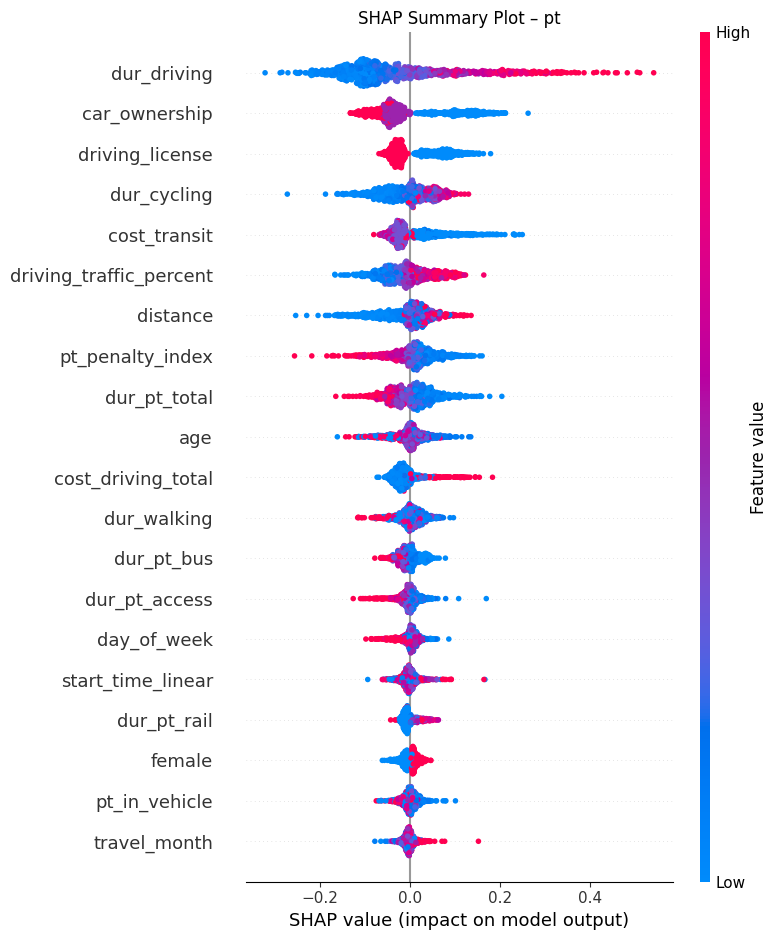

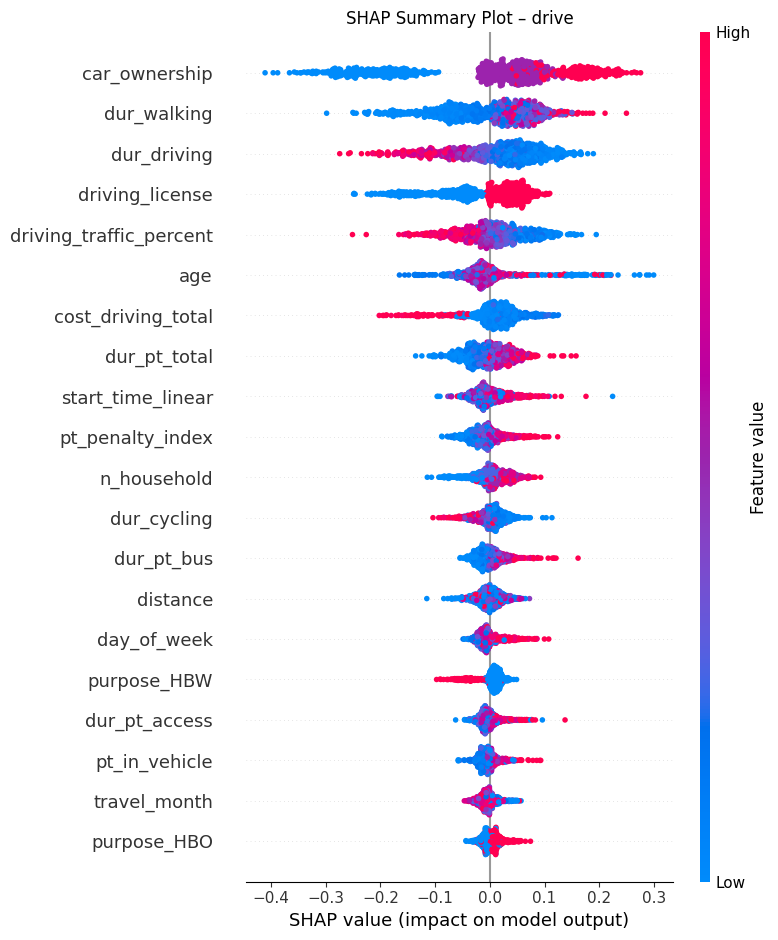

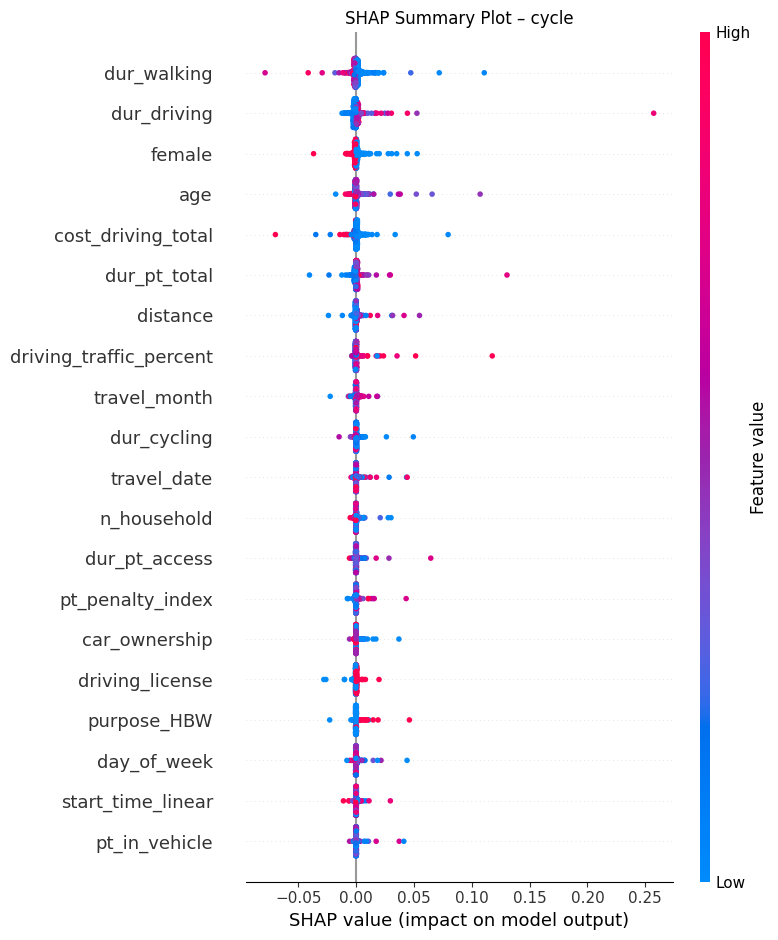

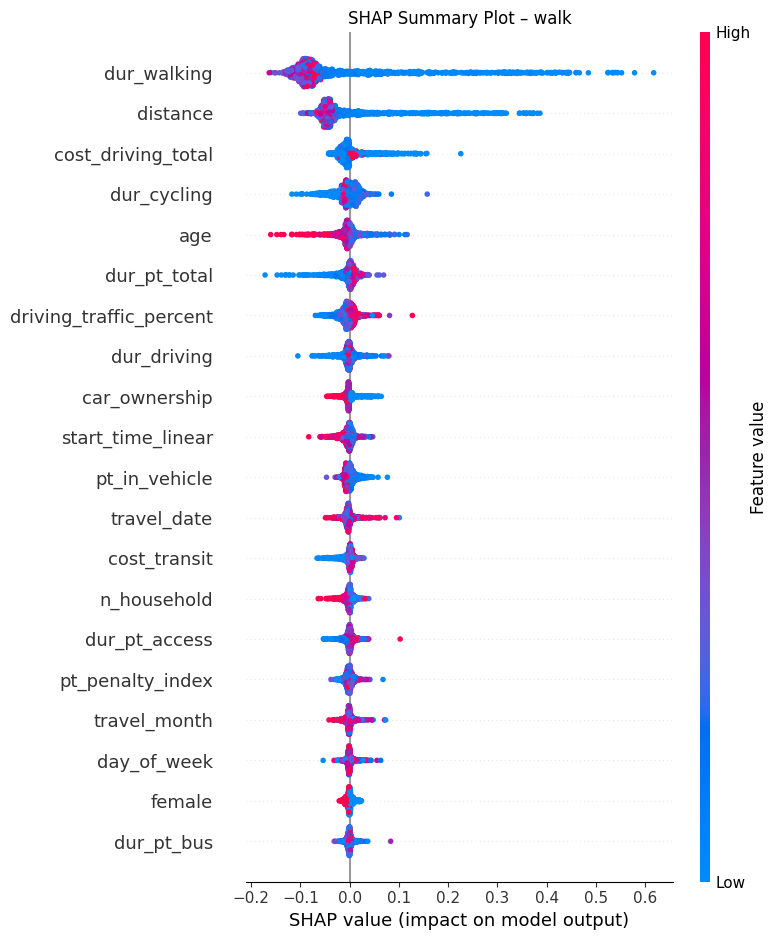

In [63]:
n_samples, n_features, n_classes = shap_values.shape

for i, class_name in enumerate(target_names):   # e.g. ["PT", "Drive", "Cycle", "Walk"]
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],          # SHAP values for class i
        X_test_sample,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Summary Plot – {class_name}")
    plt.tight_layout()
    plt.show()


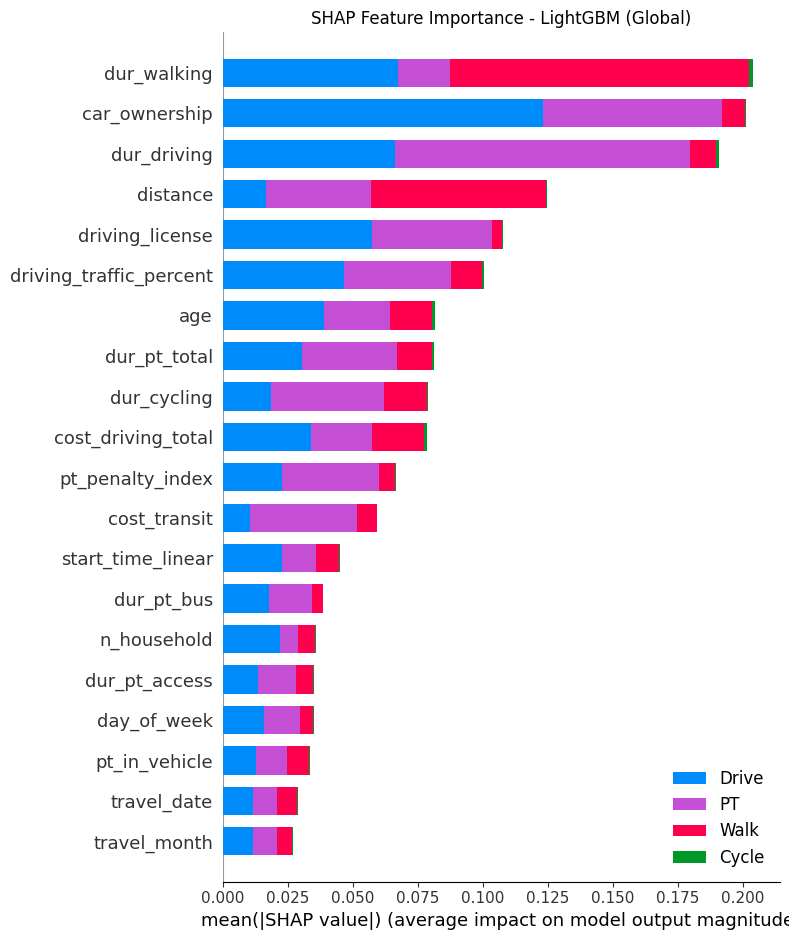


Local SHAP explanation for a single prediction:
Actual class: Drive
Predicted class: PT


C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [45]:
# Global SHAP Bar Plot (Mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="bar", class_names=target_names, show=False)
plt.title("SHAP Feature Importance - LightGBM (Global)")
plt.tight_layout()
plt.show()

# Local explanation for a single instance (first sample)
print("\nLocal SHAP explanation for a single prediction:")
print(f"Actual class: {target_names[y_test[sample_indices[0]]]}")
print(f"Predicted class: {target_names[best_lgb.predict(X_test_sample[0:1])[0]]}")


### 9.2 SHAP Interpretability for XGBoost

In [44]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer for XGBoost
# Note: Use model_output="raw" for XGBoost (SHAP will handle the transformation)
explainer_xgb = shap.TreeExplainer(best_xgb, data=X_train)

# Calculate SHAP values for the test set (using a sample for performance)
sample_size = 1000  # Use a sample for faster computation
sample_indices_xgb = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_test_sample_xgb = X_test[sample_indices_xgb]
X_test_sample_orig_xgb = X_test[sample_indices_xgb]

print("Calculating SHAP values for XGBoost...")
shap_values_xgb = explainer_xgb.shap_values(X_test_sample_xgb)

mode_labels = {0: 'pt', 1: 'drive', 2: 'cycle', 3: 'walk'}
# shap_values is a list with one array per output class
print(f"\nSHAP values computed for {len(shap_values_xgb)} classes")
print(f"Shape per class: {shap_values_xgb[0].shape}")
print(f"Sample ranges per class:")
for i, mode_name in mode_labels.items():
    print(f"  {mode_name}: [{np.min(shap_values_xgb[i]):.4f}, {np.max(shap_values_xgb[i]):.4f}]")

Calculating SHAP values for XGBoost...


100%|===================| 3998/4000 [475:27<00:14]         


SHAP values computed for 1000 classes
Shape per class: (36, 4)
Sample ranges per class:
  pt: [-1.7350, 1.0066]
  drive: [-1.6861, 0.9445]
  cycle: [-1.2482, 1.5409]
  walk: [-0.8095, 1.8921]


#### 9.2.1 XGBoost: SHAP Feature Importance Visualization

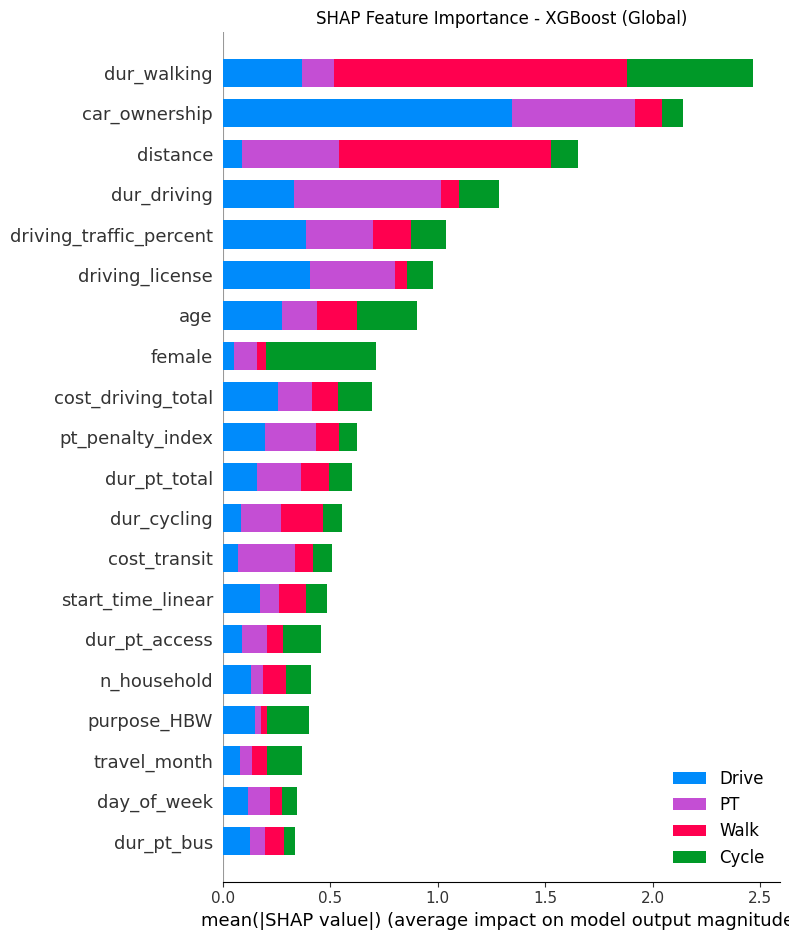


Local SHAP explanation for a single prediction:
Actual class: Drive
Predicted class: Drive


C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [51]:
# Global SHAP Bar Plot (Mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test_sample_xgb, feature_names=feature_names, plot_type="bar", class_names=target_names, show=False)
plt.title("SHAP Feature Importance - XGBoost (Global)")
plt.tight_layout()
plt.show()

# Local explanation for a single instance (first sample)
print("\nLocal SHAP explanation for a single prediction:")
print(f"Actual class: {target_names[y_test[sample_indices_xgb[0]]]}")
print(f"Predicted class: {target_names[best_lgb.predict(X_test_sample_xgb[0:1])[0]]}")
# Global SHAP Bar Plot (Mean absolute SHAP values)
